**MACHINE LEARNING ASSIGNMENT-2**

NAME : AYUSH RAKWAL

DEPT : IT [A1]

ROLL NO : 002211001006

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
import math

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc, classification_report)

import warnings
warnings.filterwarnings("ignore")
sns.set_theme(context="notebook", style="whitegrid")

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Fit model, compute metrics, return dict (no plots)."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "recall":    recall_score(y_test, y_pred, average="macro", zero_division=0),
        "f1":        f1_score(y_test, y_pred, average="macro", zero_division=0),
        "y_pred":    y_pred,
        "y_true":    y_test
    }

def plot_confusion_matrix(y_true, y_pred, title="Best Model | Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.2))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_learning_curves(estimator, X, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1
    )
    plt.figure(figsize=(5.6,4.2))
    plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train")
    plt.plot(train_sizes, val_scores.mean(axis=1),   marker="s", label="CV")
    plt.title(title); plt.xlabel("Training examples"); plt.ylabel("Score")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_multiclass_roc(models_dict, X_train, X_test, y_train, y_test, classes, title="ROC Curves (OvR)"):
    """Multi-plot ROC (OvR) per model; uses predict_proba / decision_function."""
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin  = label_binarize(y_test,  classes=classes)

    ncols = 3
    nrows = int(np.ceil(len(models_dict)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.5*nrows))
    if nrows == 1: axes = np.atleast_1d(axes)
    axes = axes.flatten()

    for ax, (name, base_model) in zip(axes, models_dict.items()):
        model = OneVsRestClassifier(base_model)
        model.fit(X_train, y_train_bin)
        try:
            y_score = model.predict_proba(X_test)
        except:
            y_score = model.decision_function(X_test)

        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            ax.plot(fpr, tpr, label=f"class {cls} (AUC={auc(fpr,tpr):.2f})")

        ax.plot([0,1], [0,1], "k--", lw=1)
        ax.set_title(name); ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
        ax.legend(loc="lower right", fontsize=9)

    for j in range(len(models_dict), len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout(); plt.show()

def bar_best_per_model(df, title):
    best = df.loc[df.groupby("model")["accuracy"].idxmax()].sort_values("accuracy", ascending=False)
    plt.figure(figsize=(8,4))
    ax = sns.barplot(data=best, x="model", y="accuracy")
    ax.bar_label(ax.containers[0], fmt="%.3f", padding=3, fontsize=9)
    plt.title(title); plt.xticks(rotation=15); plt.ylim(0,1.05); plt.tight_layout(); plt.show()
    return best

def heatmap_accuracy(df, title):
    pivot = df.pivot_table(index="model", columns="test_size", values="accuracy", aggfunc="max")
    plt.figure(figsize=(7.4,4.4))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", cbar_kws={"label":"Accuracy"})
    plt.title(title); plt.xlabel("Test size"); plt.ylabel("Model")
    plt.tight_layout(); plt.show()
    return pivot

def lines_accuracy(df, title):
    plt.figure(figsize=(8,4.5))
    for name, g in df.groupby("model"):
        g = g.sort_values("test_size")
        plt.plot(g["test_size"], g["accuracy"], marker="o", label=name)
    plt.title(title); plt.xlabel("Test size"); plt.ylabel("Accuracy")
    plt.ylim(0,1.05); plt.legend(ncol=3, fontsize=9); plt.tight_layout(); plt.show()

def radar_from_best(df, title):
    best = df.loc[df.groupby("model")["accuracy"].idxmax()]
    metrics = ["accuracy","precision","recall","f1"]

    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    for _, row in best.iterrows():
        vals = [row[m] for m in metrics] + [row["accuracy"]]
        vals = [row[m] for m in metrics] + [row[metrics[0]]]
        vals = [row[m] for m in metrics]; vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, label=row["model"])
        ax.fill(angles, vals, alpha=0.1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title(title, y=1.08)
    ax.set_rlim(0,1)
    plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.10))
    plt.tight_layout(); plt.show()


In [ ]:
import os
from matplotlib.offsetbox import AnchoredText

def _ensure_dir(path):
    if path:
        os.makedirs(path, exist_ok=True)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "recall":    recall_score(y_test, y_pred, average="macro", zero_division=0),
        "f1":        f1_score(y_test, y_pred, average="macro", zero_division=0),
        "y_pred":    y_pred,
        "y_true":    y_test,
        "model":     model
    }

def plot_confusion_matrix(y_true, y_pred, title="Best Model | Confusion Matrix", cmap="Blues", save_path=None, ax=None):
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        plt.figure(figsize=(4.8,4.2))
        ax = plt.gca()
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap=cmap, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if save_path:
        _ensure_dir(os.path.dirname(save_path))
        plt.tight_layout()
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    if ax is None:
        plt.tight_layout(); plt.show()

def plot_cm_with_metrics(y_true, y_pred, title, metrics, cmap="Blues", save_path=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.2,4.4))
    plot_confusion_matrix(y_true, y_pred, title=title, cmap=cmap, save_path=None, ax=ax)
    txt = "\n".join([
        f"Acc : {metrics['accuracy']:.3f}",
        f"Prec: {metrics['precision']:.3f}",
        f"Rec : {metrics['recall']:.3f}",
        f"F1  : {metrics['f1']:.3f}",
    ])
    at = AnchoredText(txt, loc="upper right", prop=dict(size=9), frameon=True, pad=0.3, borderpad=0.5)
    ax.add_artist(at)
    if save_path:
        _ensure_dir(os.path.dirname(save_path))
        plt.tight_layout(); plt.savefig(save_path, dpi=200, bbox_inches="tight")

def plot_cm_grid(entries, ncols=2, cmap="Blues", suptitle=None, save_path=None):
    n = len(entries); nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4.6*nrows))
    axes = np.atleast_2d(axes).reshape(-1)
    for i, e in enumerate(entries):
        plot_cm_with_metrics(e["y_true"], e["y_pred"], e["title"], e["metrics"], cmap=cmap, ax=axes[i])
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    if suptitle: fig.suptitle(suptitle, y=1.02, fontsize=14)
    plt.tight_layout()
    if save_path:
        _ensure_dir(os.path.dirname(save_path))
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

def plot_learning_curves(estimator, X, y, title="Learning Curve", cv=5, save_path=None):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1
    )
    plt.figure(figsize=(5.6,4.2))
    plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train")
    plt.plot(train_sizes, val_scores.mean(axis=1),   marker="s", label="CV")
    plt.title(title); plt.xlabel("Training examples"); plt.ylabel("Score")
    plt.legend(); plt.tight_layout()
    if save_path:
        _ensure_dir(os.path.dirname(save_path))
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

def plot_mlp_loss_from_fitted(fitted_estimator_or_pipeline, title="MLP Training Loss", save_path=None):
    clf = fitted_estimator_or_pipeline
    if hasattr(fitted_estimator_or_pipeline, "named_steps"):
        clf = fitted_estimator_or_pipeline.named_steps.get("clf", fitted_estimator_or_pipeline)
    if hasattr(clf, "loss_curve_") and clf.loss_curve_:
        plt.figure(figsize=(5.6,4.2))
        plt.plot(range(1, len(clf.loss_curve_)+1), clf.loss_curve_, marker="o")
        plt.title(title); plt.xlabel("Iteration"); plt.ylabel("Loss"); plt.tight_layout()
        if save_path:
            _ensure_dir(os.path.dirname(save_path))
            plt.savefig(save_path, dpi=200, bbox_inches="tight")
        plt.show()
    else:
        print("No loss_curve_ found (is the model an MLP and already fitted?).")

def plot_multiclass_roc(models_dict, X_train, X_test, y_train, y_test, classes, title="ROC Curves (OvR)", save_path=None):
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin  = label_binarize(y_test,  classes=classes)

    ncols = 3
    nrows = int(np.ceil(len(models_dict)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.5*nrows))
    if nrows == 1: axes = np.atleast_1d(axes)
    axes = axes.flatten()

    for ax, (name, base_model) in zip(axes, models_dict.items()):
        model = OneVsRestClassifier(base_model)
        model.fit(X_train, y_train_bin)
        try:
            y_score = model.predict_proba(X_test)
        except:
            y_score = model.decision_function(X_test)

        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            ax.plot(fpr, tpr, label=f"class {cls} (AUC={auc(fpr,tpr):.2f})")

        ax.plot([0,1], [0,1], "k--", lw=1)
        ax.set_title(name); ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
        ax.legend(loc="lower right", fontsize=9)

    for j in range(len(models_dict), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    if save_path:
        _ensure_dir(os.path.dirname(save_path))
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

def save_roc_per_model(models_dict, X_train, X_test, y_train, y_test, classes, outdir, prefix="ROC"):
    _ensure_dir(outdir)
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin  = label_binarize(y_test,  classes=classes)
    for name, base_model in models_dict.items():
        model = OneVsRestClassifier(base_model)
        model.fit(X_train, y_train_bin)
        try:
            y_score = model.predict_proba(X_test)
        except:
            y_score = model.decision_function(X_test)

        plt.figure(figsize=(6,4.6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"class {cls} (AUC={auc(fpr,tpr):.2f})")
        plt.plot([0,1], [0,1], "k--", lw=1)
        plt.title(f"{prefix} | {name}")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(loc="lower right", fontsize=9)
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, f"{prefix}_{name}.png"), dpi=200, bbox_inches="tight")
        plt.show()

def bar_best_per_model(df, title, save_path=None):
    best = df.loc[df.groupby("model")["accuracy"].idxmax()].sort_values("accuracy", ascending=False)
    plt.figure(figsize=(8,4))
    ax = sns.barplot(data=best, x="model", y="accuracy")
    ax.bar_label(ax.containers[0], fmt="%.3f", padding=3, fontsize=9)
    plt.title(title); plt.xticks(rotation=15); plt.ylim(0,1.05); plt.tight_layout()
    if save_path:
        _ensure_dir(os.path.dirname(save_path))
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    return best

def heatmap_accuracy(df, title, save_path=None):
    pivot = df.pivot_table(index="model", columns="test_size", values="accuracy", aggfunc="max")
    plt.figure(figsize=(7.4,4.4))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", cbar_kws={"label":"Accuracy"})
    plt.title(title); plt.xlabel("Test size"); plt.ylabel("Model")
    plt.tight_layout()
    if save_path:
        _ensure_dir(os.path.dirname(save_path))
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    return pivot

def lines_accuracy(df, title, save_path=None):
    plt.figure(figsize=(8,4.5))
    for name, g in df.groupby("model"):
        g = g.sort_values("test_size")
        plt.plot(g["test_size"], g["accuracy"], marker="o", label=name)
    plt.title(title); plt.xlabel("Test size"); plt.ylabel("Accuracy")
    plt.ylim(0,1.05); plt.legend(ncol=3, fontsize=9); plt.tight_layout()
    if save_path:
        _ensure_dir(os.path.dirname(save_path))
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

# **DATASET : WINE**

Wine: (178, 13) Classes: [0, 1, 2]


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


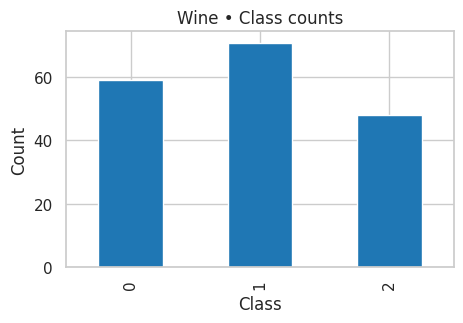

In [ ]:
from sklearn.datasets import load_wine

wine = load_wine()
X_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
y_wine = pd.Series(wine.target, name="target")
classes_wine = np.unique(y_wine)

print("Wine:", X_wine.shape, "Classes:", classes_wine.tolist())
display(X_wine.head())

plt.figure(figsize=(4.8,3.4))
y_wine.value_counts().sort_index().plot(kind="bar", color="tab:blue")
plt.title("Wine • Class counts"); plt.xlabel("Class"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


Implement and compare the following ML classifiers and show the classification results (Accuracy, Precision, Recall, F-score, confusion matrix)
1. SVM classifier (Linear, Polynomial, Gaussian, & Sigmoid)
2. MLP classifier
3. Random Forest classifier

Apply different values of train-test set splits (Eg.: 50:50, 60:40, 70:30 and 80:20) and report the corresponding results.

,test_size,model,accuracy,precision,recall,f1
0,0.2,MLP,0.972222,0.977778,0.966667,0.970962
1,0.3,MLP,1.000000,1.000000,1.000000,1.000000
2,0.4,MLP,0.972222,0.974359,0.977011,0.974762
3,0.5,MLP,0.955056,0.955177,0.957540,0.955751
4,0.2,RandomForest,1.000000,1.000000,1.000000,1.000000
5,0.3,RandomForest,1.000000,1.000000,1.000000,1.000000
6,0.4,RandomForest,0.986111,0.986667,0.988506,0.987349
7,0.5,RandomForest,0.977528,0.975914,0.980952,0.977929
8,0.2,SVM-Linear,0.944444,0.950549,0.942857,0.945313
9,0.3,SVM-Linear,0.962963,0.966583,0.961905,0.963624


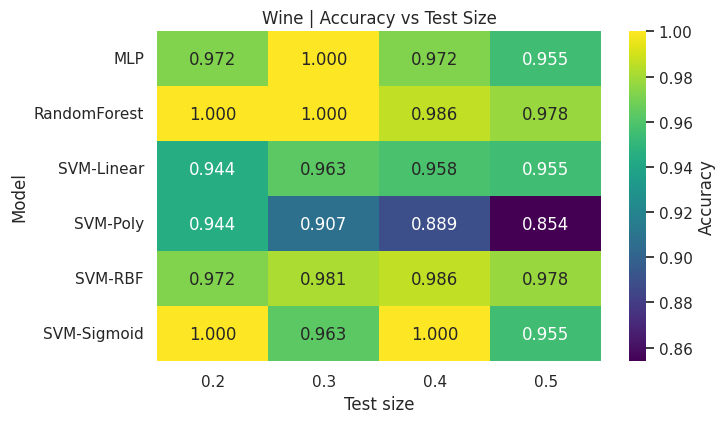


Pivot (max accuracy per model × test_size):


test_size,0.2,0.3,0.4,0.5
model,,,,
MLP,0.972222,1.000000,0.972222,0.955056
RandomForest,1.000000,1.000000,0.986111,0.977528
SVM-Linear,0.944444,0.962963,0.958333,0.955056
SVM-Poly,0.944444,0.907407,0.888889,0.853933
SVM-RBF,0.972222,0.981481,0.986111,0.977528
SVM-Sigmoid,1.000000,0.962963,1.000000,0.955056



Best accuracy per model:


,model,test_size,accuracy,precision,recall,f1
0,MLP,0.3,1.000000,1.000000,1.000000,1.000000
1,RandomForest,0.2,1.000000,1.000000,1.000000,1.000000
2,SVM-Sigmoid,0.2,1.000000,1.000000,1.000000,1.000000
3,SVM-RBF,0.4,0.986111,0.988889,0.982456,0.985341
4,SVM-Linear,0.3,0.962963,0.966583,0.961905,0.963624
5,SVM-Poly,0.2,0.944444,0.958333,0.933333,0.940741


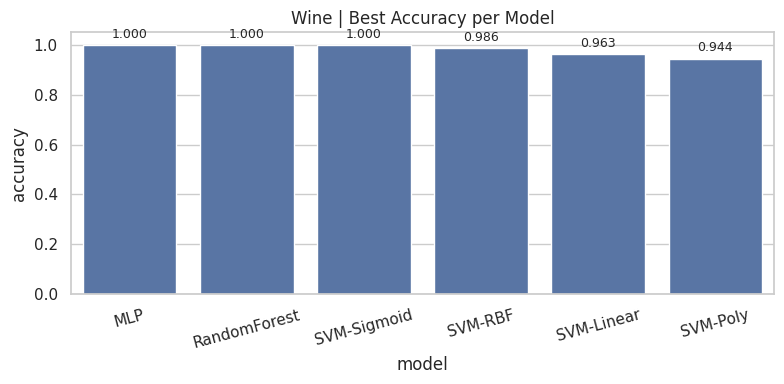

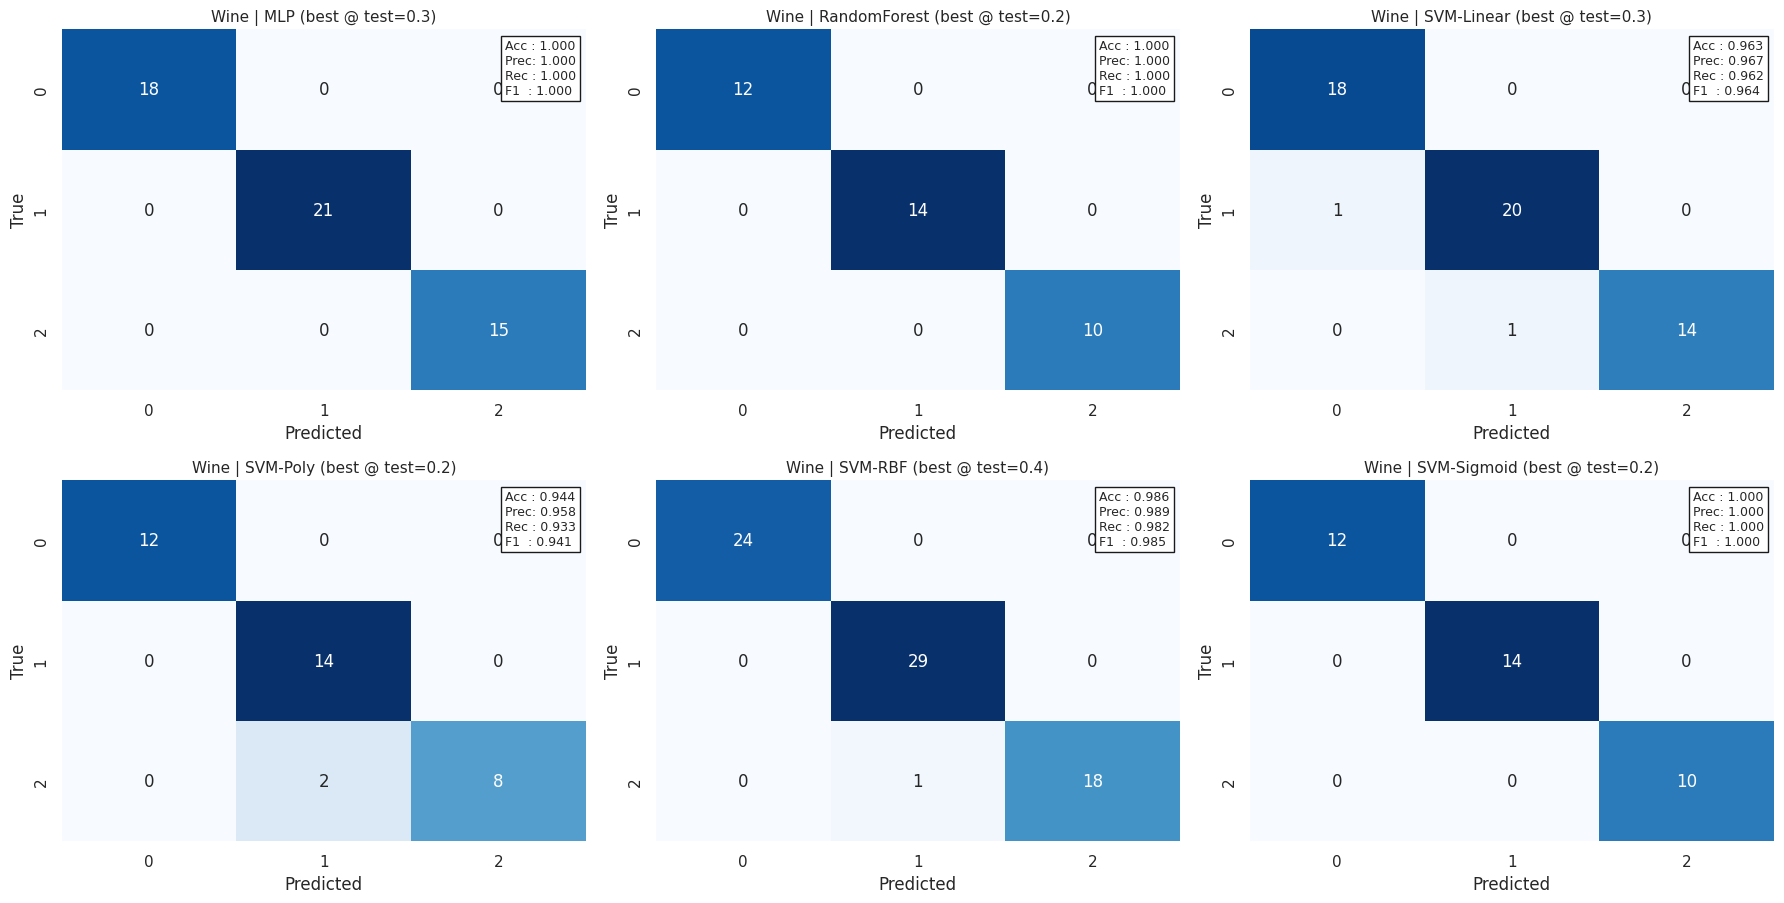

In [ ]:
import math
from matplotlib.offsetbox import AnchoredText

pipe_w_svm_lin  = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="linear", probability=True))])
pipe_w_svm_poly = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="poly",   probability=True))])
pipe_w_svm_rbf  = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf",    probability=True))])
pipe_w_svm_sig  = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="sigmoid",probability=True))])
pipe_w_mlp      = Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(max_iter=200, random_state=42))])
pipe_w_rf       = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))])

w_models = {
    "SVM-Linear":  pipe_w_svm_lin,
    "SVM-Poly":    pipe_w_svm_poly,
    "SVM-RBF":     pipe_w_svm_rbf,
    "SVM-Sigmoid": pipe_w_svm_sig,
    "MLP":         pipe_w_mlp,
    "RandomForest":pipe_w_rf
}
w_test_sizes = [0.2, 0.3, 0.4, 0.5]

def plot_cm_on_ax(ax, y_true, y_pred, title, metrics):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", ax=ax)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    txt = "\n".join([
        f"Acc : {metrics['accuracy']:.3f}",
        f"Prec: {metrics['precision']:.3f}",
        f"Rec : {metrics['recall']:.3f}",
        f"F1  : {metrics['f1']:.3f}",
    ])
    at = AnchoredText(txt, loc="upper right", prop=dict(size=9), frameon=True, pad=0.3, borderpad=0.5)
    ax.add_artist(at)

wine_rows = []
preds_map = {}

for ts in w_test_sizes:
    Xtr, Xte, ytr, yte = train_test_split(X_wine, y_wine, test_size=ts, stratify=y_wine, random_state=42)
    for name, m in w_models.items():
        res = evaluate_model(m, Xtr, Xte, ytr, yte)
        wine_rows.append({
            "test_size": ts, "model": name,
            "accuracy":res["accuracy"], "precision":res["precision"],
            "recall":res["recall"], "f1":res["f1"]
        })
        preds_map[(name, ts)] = {"y_true": res["y_true"], "y_pred": res["y_pred"]}

df_wine = pd.DataFrame(wine_rows).sort_values(["model","test_size"]).reset_index(drop=True)

display(df_wine)

pivot_wine = heatmap_accuracy(df_wine, title="Wine | Accuracy vs Test Size")
print("\nPivot (max accuracy per model × test_size):")
display(pivot_wine)

best_rows = df_wine.loc[df_wine.groupby("model")["accuracy"].idxmax()].sort_values("accuracy", ascending=False).reset_index(drop=True)
print("\nBest accuracy per model:")
display(best_rows[["model","test_size","accuracy","precision","recall","f1"]])
_ = bar_best_per_model(df_wine, title="Wine | Best Accuracy per Model")

def best_confusion_data(model_name):
    r = df_wine[df_wine["model"] == model_name]
    if r.empty: return None
    r = r.loc[r["accuracy"].idxmax()]
    ts = r["test_size"]
    preds = preds_map[(model_name, ts)]
    metrics = {"accuracy": r["accuracy"], "precision": r["precision"], "recall": r["recall"], "f1": r["f1"]}
    title = f"{model_name} (best @ test={ts})"
    return preds["y_true"], preds["y_pred"], title, metrics

models_to_plot = ["MLP", "RandomForest", "SVM-Linear", "SVM-Poly", "SVM-RBF", "SVM-Sigmoid"]

n = len(models_to_plot)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4.6*nrows))

axes = np.atleast_2d(axes).reshape(-1)

for i, model_name in enumerate(models_to_plot):
    ax = axes[i]
    data = best_confusion_data(model_name)
    if data is None:
        ax.axis("off")
        continue
    y_true, y_pred, title, metrics = data
    plot_cm_on_ax(ax, y_true, y_pred, f"Wine | {title}", metrics)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

**OBSERVATIONS:**

The Wine dataset has 178 instances and 13 features.
There are 3 classes, and the class distribution is relatively balanced, which is good for training classification models.

Model Performance Across Test Sizes :

The table and heatmap show the accuracy of different models (MLP, RandomForest, SVM variants) across various test sizes (0.2, 0.3, 0.4, 0.5).
Several models, including MLP, RandomForest, and SVM-Sigmoid, achieved perfect or near-perfect accuracy (1.000) at certain test sizes, indicating they are well-suited for this dataset.
SVM-Poly generally performed worse than other SVM kernels, especially as the test size increased.
The heatmap visually confirms that accuracy tends to be high for most models, with SVM-Poly being a clear outlier with lower accuracy values.

**Best Accuracy per Model:**

The bar plot and table summarizing the best accuracy per model highlight that MLP, RandomForest, and SVM-Sigmoid achieved the highest accuracies (1.000).
SVM-RBF also performed very well, with a peak accuracy of 0.986.
SVM-Linear and SVM-Poly had slightly lower peak accuracies compared to the others.


**Confusion Matrices for Best Settings:**

The confusion matrices for the best-performing settings of each model provide insights into where misclassifications occur.
For models with 100% accuracy (MLP, RandomForest, SVM-Sigmoid), the confusion matrices show perfect classification with all instances on the diagonal.
For models with slightly lower accuracy (e.g., SVM-Linear, SVM-RBF, SVM-Poly), the confusion matrices show the specific classes that were misclassified. For example, SVM-Linear misclassified some instances of class 1 as class 2, and vice versa.


Overall, the Wine dataset appears to be relatively easy to classify, with several models achieving high accuracy. MLP, RandomForest, and SVMs with RBF and Sigmoid kernels seem to be particularly effective on this dataset.

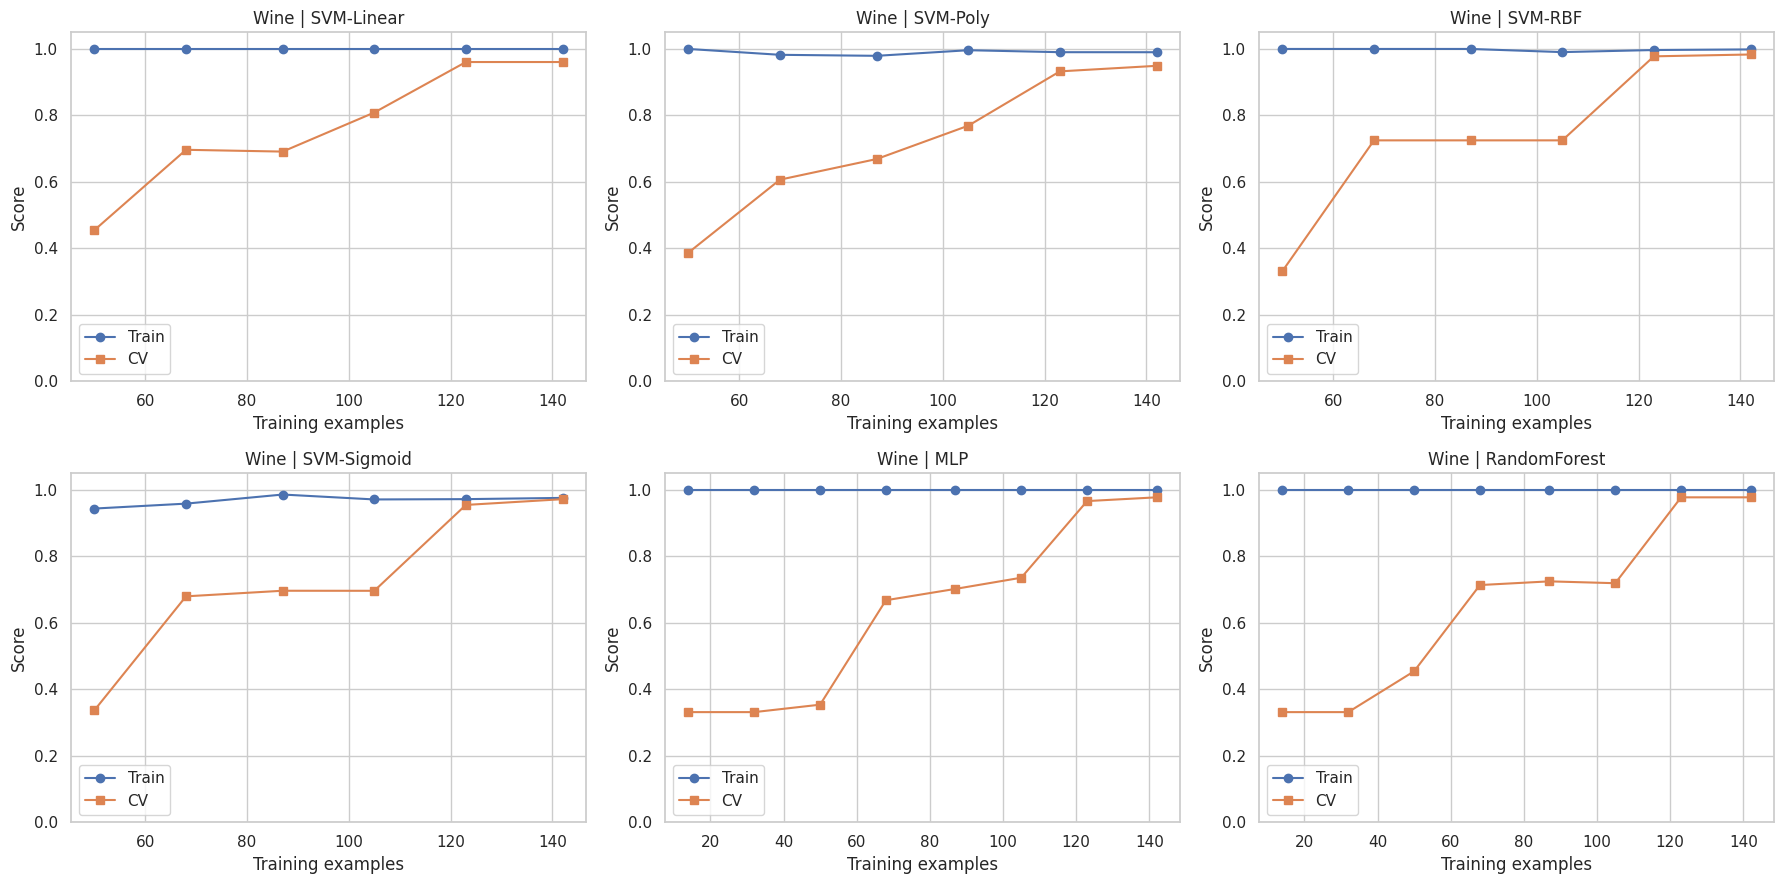

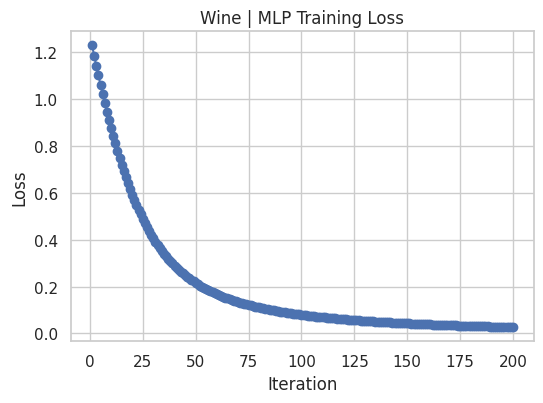

In [ ]:
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.ravel()
order6 = ["SVM-Linear","SVM-Poly","SVM-RBF","SVM-Sigmoid","MLP","RandomForest"]

for ax, name in zip(axes, order6):
    est = w_models[name]
    train_sizes, train_scores, val_scores = learning_curve(
        est, X_wine, y_wine, cv=5,
        train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1
    )
    ax.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train")
    ax.plot(train_sizes, val_scores.mean(axis=1),   marker="s", label="CV")
    ax.set_title(f"Wine | {name}")
    ax.set_xlabel("Training examples"); ax.set_ylabel("Score")
    ax.set_ylim(0, 1.05); ax.legend()

plt.tight_layout(); plt.show()

mlp_wine = w_models["MLP"].fit(X_wine, y_wine)
plot_mlp_loss_from_fitted(mlp_wine, title="Wine | MLP Training Loss")


**Observations from Learning Curves :**

Looking at the learning curves for all six models, most models show a rapid increase in both training and cross-validation scores as the number of training examples increases, quickly converging to a high score. This indicates that these models are able to learn effectively from the data.
Some models, like SVM-Linear, SVM-RBF, and SVM-Sigmoid, show very little gap between training and cross-validation scores, suggesting low variance and good generalization.

MLP and RandomForest also show good performance, with the training score slightly higher than the cross-validation score, which is typical.

The MLP training loss curve shows a steady decrease, indicating that the model is learning and converging during training.

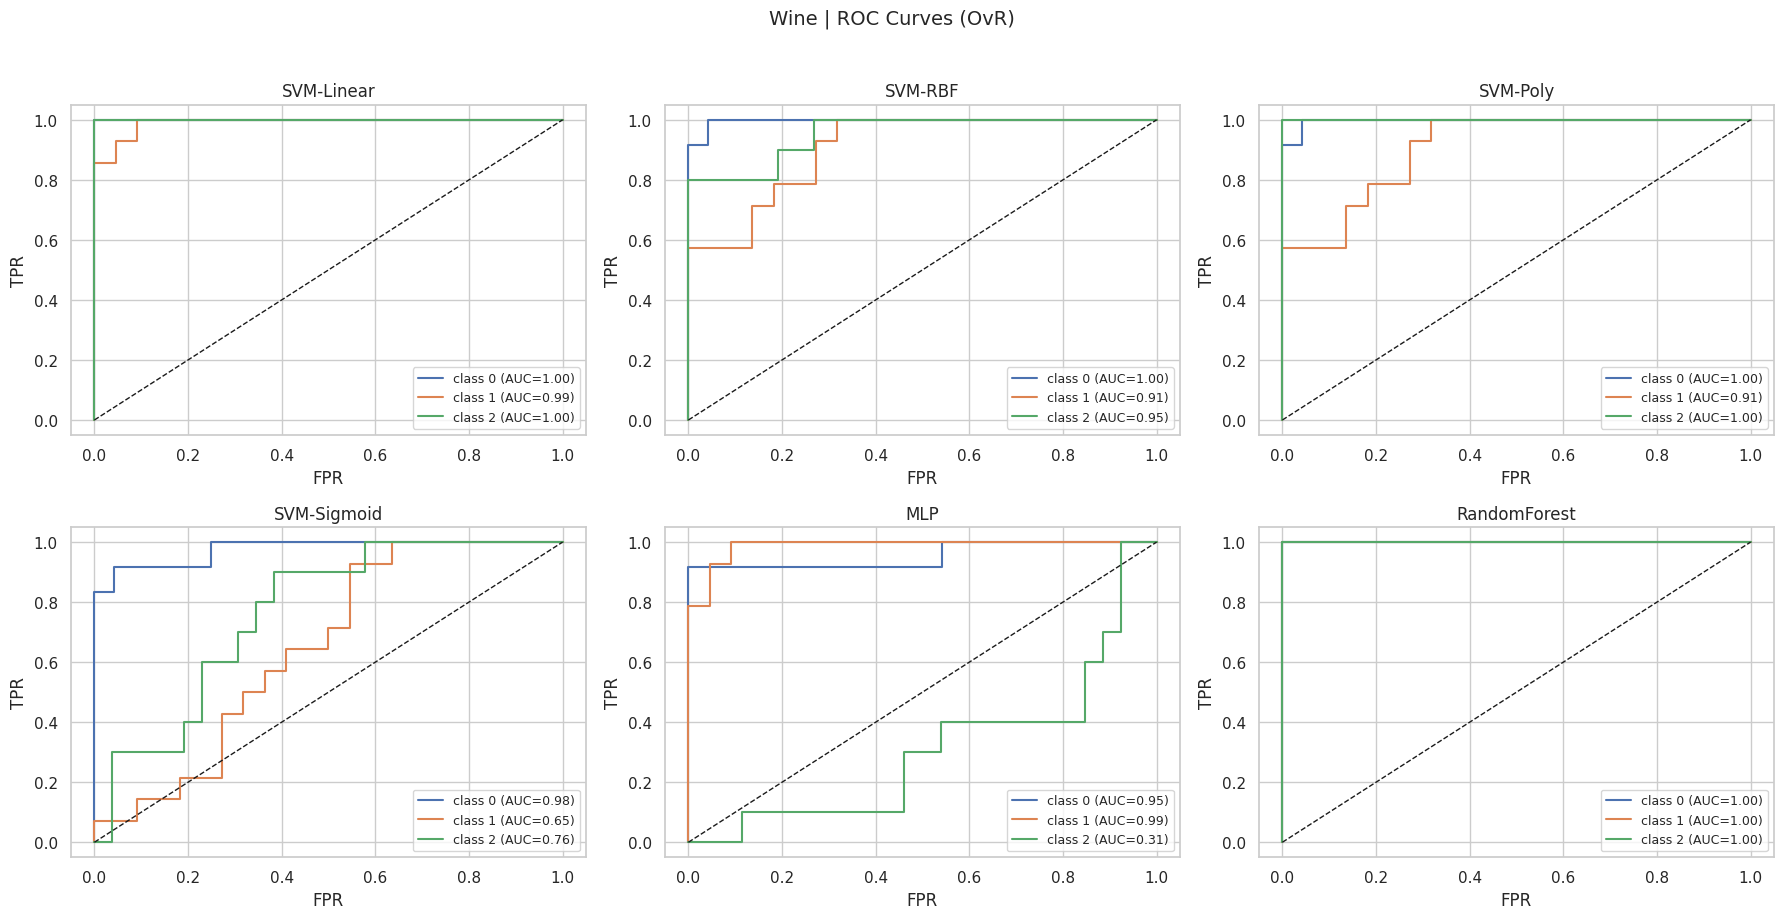

In [ ]:
Xtr, Xte, ytr, yte = train_test_split(X_wine, y_wine, test_size=0.2, stratify=y_wine, random_state=42)
roc_w_models = {
    "SVM-Linear": SVC(kernel="linear", probability=True, random_state=42),
    "SVM-RBF":    SVC(kernel="rbf",    probability=True, random_state=42),
    "SVM-Poly":   SVC(kernel="poly",   probability=True, random_state=42),
    "SVM-Sigmoid":SVC(kernel="sigmoid",probability=True, random_state=42),
    "MLP":        MLPClassifier(max_iter=300, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
}
plot_multiclass_roc(roc_w_models, Xtr, Xte, ytr, yte, classes=classes_wine, title="Wine | ROC Curves (OvR)")


**OBERVATIONS:**

Overall Performance: Most models show strong performance with AUC values close to 1.00 for several classes, indicating excellent discrimination ability.

SVM-Linear, SVM-RBF, SVM-Poly: These SVM kernels generally perform very well, with high AUC values for all three classes. This suggests they are effective in separating the different wine types.

SVM-Sigmoid: While also performing well for some classes (e.g., class 0), the SVM-Sigmoid shows slightly lower AUC values for other classes (e.g., class 2 with an AUC of 0.76), indicating it's not as consistent across all classes compared to Linear, RBF, or Poly kernels on this dataset.

MLP: The MLP model also demonstrates good performance with high AUC values, similar to the better-performing SVM kernels.

RandomForest: The Random Forest classifier shows excellent performance with high AUC values for all classes, indicating its ability to effectively distinguish between the different wine classes.

In summary, the ROC curves reinforce the earlier observations that most models perform very well on the Wine dataset. SVM with Linear, RBF, and Poly kernels, along with MLP and Random Forest, show strong discriminative power across all classes. The SVM-Sigmoid performs slightly less consistently across all classes.

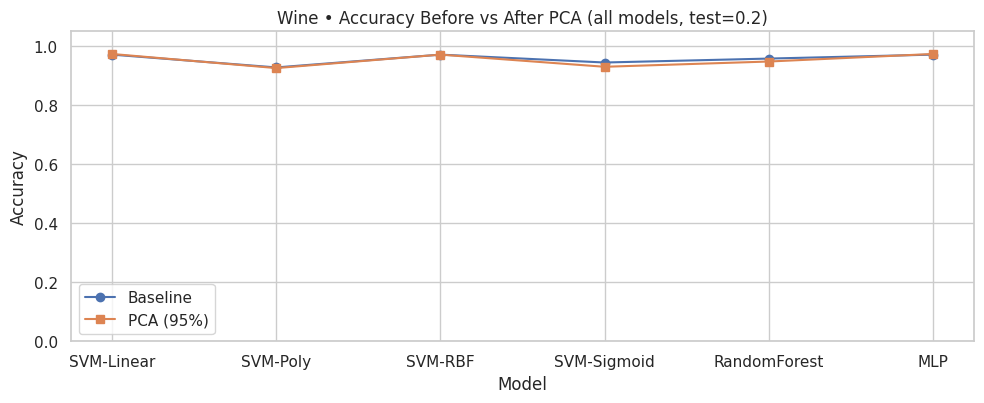

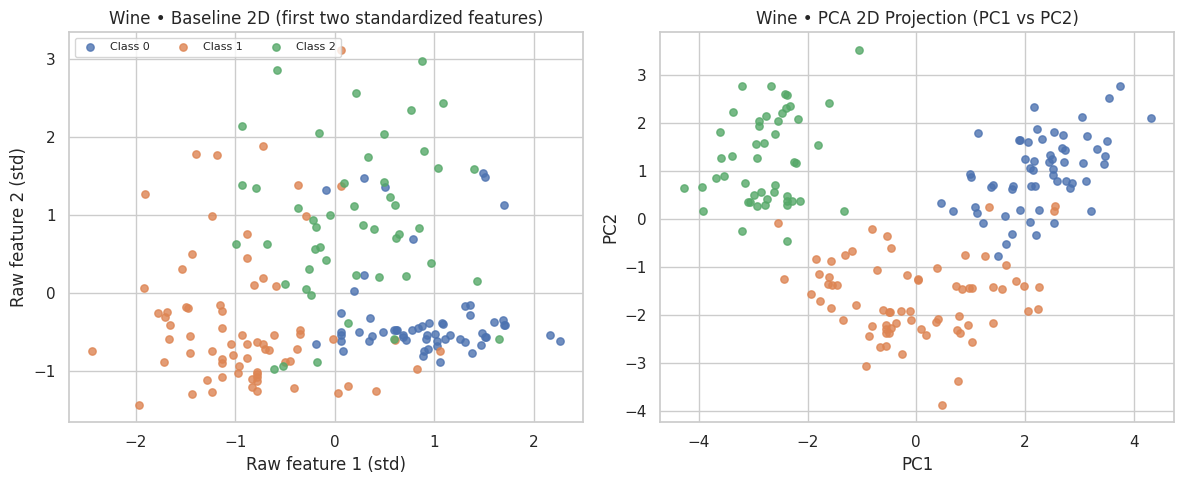

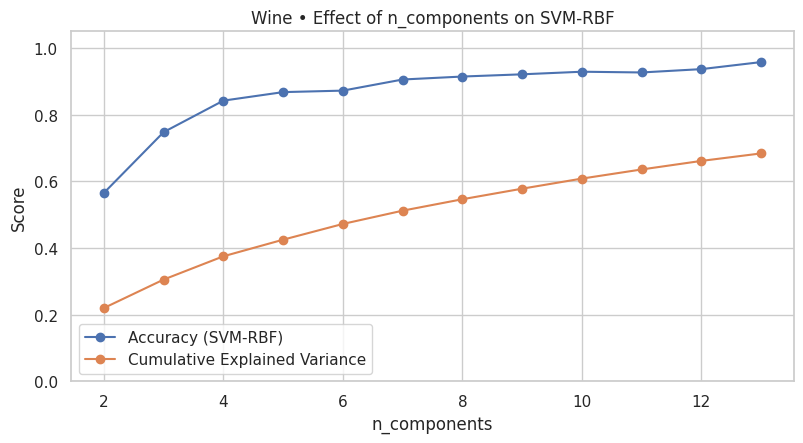

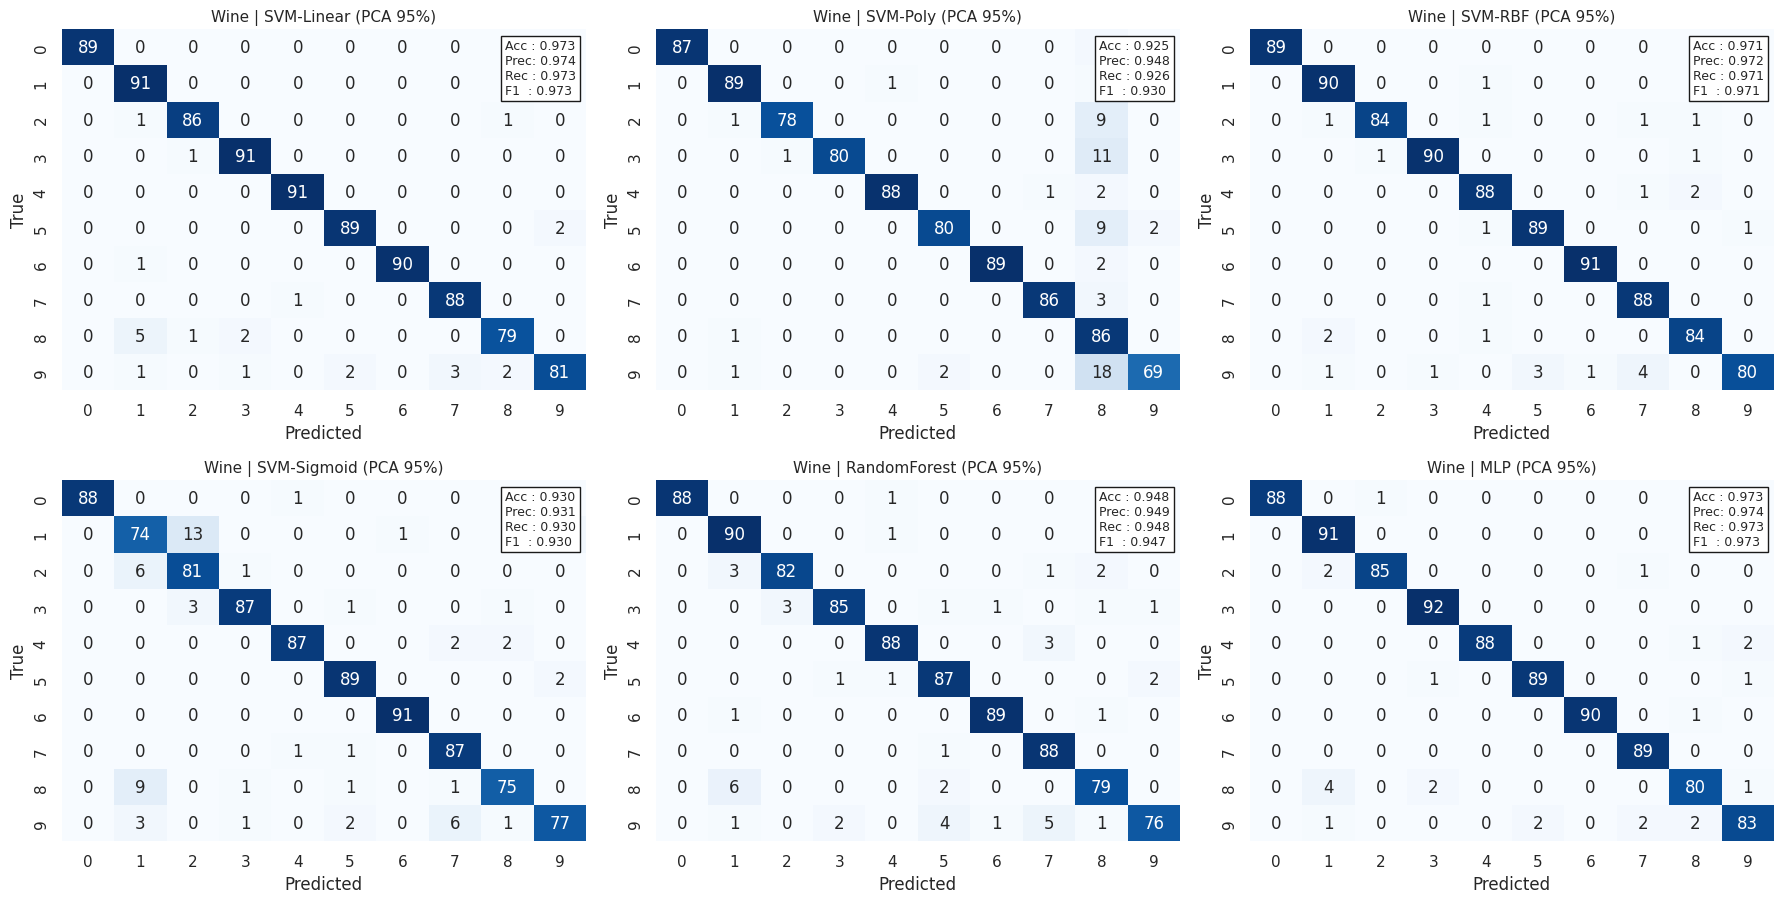

In [ ]:
from copy import deepcopy

base_all_w = {
    "SVM-Linear":  Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="linear",  probability=True))]),
    "SVM-Poly":    Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="poly",    probability=True))]),
    "SVM-RBF":     Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf",     probability=True))]),
    "SVM-Sigmoid": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="sigmoid", probability=True))]),
    "RandomForest":Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))]),
    "MLP":         Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(max_iter=200, random_state=42))]),
}
pca_all_w = {
    "SVM-Linear":  make_pca(SVC(kernel="linear",  probability=True)),
    "SVM-Poly":    make_pca(SVC(kernel="poly",    probability=True)),
    "SVM-RBF":     make_pca(SVC(kernel="rbf",     probability=True)),
    "SVM-Sigmoid": make_pca(SVC(kernel="sigmoid", probability=True)),
    "RandomForest":make_pca(RandomForestClassifier(random_state=42)),
    "MLP":         make_pca(MLPClassifier(max_iter=200, random_state=42)),
}

rows_base_all, rows_pca_all = [], []
for name, est in base_all_w.items():
    res = evaluate_model(deepcopy(est), Xtr, Xte, ytr, yte)
    rows_base_all.append({"model": name, "accuracy": res["accuracy"]})

for name, est in pca_all_w.items():
    res = evaluate_model(deepcopy(est), Xtr, Xte, ytr, yte)
    rows_pca_all.append({"model": name, "accuracy": res["accuracy"]})

df_base_all = pd.DataFrame(rows_base_all).set_index("model")
df_pca_all  = pd.DataFrame(rows_pca_all).set_index("model")

order6 = ["SVM-Linear","SVM-Poly","SVM-RBF","SVM-Sigmoid","RandomForest","MLP"]
plt.figure(figsize=(10, 4.2))
plt.plot(order6, df_base_all.loc[order6, "accuracy"].values, marker="o", label="Baseline")
plt.plot(order6, df_pca_all.loc[order6,  "accuracy"].values, marker="s", label="PCA (95%)")
plt.ylim(0, 1.05); plt.xlabel("Model"); plt.ylabel("Accuracy")
plt.title("Wine • Accuracy Before vs After PCA (all models, test=0.2)")
plt.legend(); plt.tight_layout(); plt.show()

X_std = StandardScaler().fit_transform(X_wine)
plt.figure(figsize=(12, 5.0))

plt.subplot(1, 2, 1)
for cls in np.unique(y_wine):
    idx = (y_wine == cls)
    plt.scatter(X_std[idx, 0], X_std[idx, 1], s=28, alpha=0.8, label=f"Class {cls}")
plt.xlabel("Raw feature 1 (std)"); plt.ylabel("Raw feature 2 (std)")
plt.title("Wine • Baseline 2D (first two standardized features)")
plt.legend(ncol=3, fontsize=8)

plt.subplot(1, 2, 2)
pca2 = PCA(n_components=2, svd_solver="full").fit(X_std)
X_2d = pca2.transform(X_std)
for cls in np.unique(y_wine):
    idx = (y_wine == cls)
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], s=28, alpha=0.8, label=f"Class {cls}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Wine • PCA 2D Projection (PC1 vs PC2)")
plt.tight_layout(); plt.show()

clf_name = "SVM-RBF"
estimator_for_sweep = {
    "SVM-RBF": SVC(kernel="rbf", probability=True),
    "MLP": MLPClassifier(max_iter=200, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
}[clf_name]

max_k = min(X_wine.shape[1], 13)
ks = list(range(2, max_k + 1))
accs, cumvar = [], []

sc_tr = StandardScaler().fit(Xtr)
Xtr_s = sc_tr.transform(Xtr); Xte_s = sc_tr.transform(Xte)

for k in ks:
    pca_k = PCA(n_components=k, svd_solver="full").fit(Xtr_s)
    Xtr_p = pca_k.transform(Xtr_s); Xte_p = pca_k.transform(Xte_s)
    clf = deepcopy(estimator_for_sweep).fit(Xtr_p, ytr)
    y_pred = clf.predict(Xte_p)
    accs.append(accuracy_score(yte, y_pred))
    cumvar.append(pca_k.explained_variance_ratio_.sum())

plt.figure(figsize=(8.2, 4.6))
plt.plot(ks, accs,   marker="o", label=f"Accuracy ({clf_name})")
plt.plot(ks, cumvar, marker="o", label="Cumulative Explained Variance")
plt.xlabel("n_components"); plt.ylabel("Score")
plt.title(f"Wine • Effect of n_components on {clf_name}")
plt.ylim(0, 1.05); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

rows_pca_all = []
pca_preds_all = {}

for name, est in pca_all_w.items():
    res = evaluate_model(deepcopy(est), Xtr, Xte, ytr, yte)
    rows_pca_all.append({"model": name, "accuracy": res["accuracy"]})
    pca_preds_all[name] = {
        "y_true": res["y_true"],
        "y_pred": res["y_pred"],
        "metrics": {k: res[k] for k in ["accuracy","precision","recall","f1"]}
    }

df_pca_all  = pd.DataFrame(rows_pca_all).set_index("model")

order6 = ["SVM-Linear","SVM-Poly","SVM-RBF","SVM-Sigmoid","RandomForest","MLP"]


fig, axes = plt.subplots(nrows, ncols, figsize=(18, 9.2))
axes = np.atleast_2d(axes).reshape(-1)
for i, name in enumerate(order6):
    ax = axes[i]
    y_true = pca_preds_all[name]["y_true"]
    y_pred = pca_preds_all[name]["y_pred"]
    mets   = pca_preds_all[name]["metrics"]
    plot_cm_with_metrics_local(ax, y_true, y_pred, f"Wine | {name} (PCA 95%)", mets)
plt.tight_layout(); plt.show()



**OBSERVATIONS:**

Accuracy Before vs After PCA:
The plot comparing the accuracy of models before and after applying PCA (with 95% explained variance) shows that for most models, PCA has a minimal impact on performance. Some models like SVM-Sigmoid and MLP show a slight decrease in accuracy after PCA, while others remain largely unchanged. This suggests that for the Wine dataset, which has a relatively low number of features (13), PCA might not be significantly beneficial for improving model performance when aiming for 95% explained variance.

2D Baseline vs PCA Projection:
The scatter plot of the first two standardized raw features shows some separation between the classes, but there is still significant overlap, making linear separation difficult in this 2D space.
The PCA 2D projection plot (PC1 vs PC2) shows a much clearer separation between the three classes. The data points for each class tend to cluster together in distinct regions of the PCA space. This indicates that the first two principal components capture important variance in the data that helps in discriminating between the classes.

Effect of n_components on SVM-RBF:
The plot showing the effect of the number of PCA components on the accuracy of the SVM-RBF model and the cumulative explained variance reveals that:
The cumulative explained variance increases as more components are included, as expected. Around 95% of the variance is explained by approximately 8 components.
The accuracy of the SVM-RBF model on the test set also increases with the number of components, reaching a plateau around 5 components. Beyond 5 components, adding more components does not significantly improve accuracy and seems to slightly decrease it in some cases.

This suggests that for the Wine dataset with SVM-RBF, a smaller number of principal components (around 5-8) can capture most of the relevant information for classification and potentially lead to slightly better or similar performance compared to using all features, while also reducing dimensionality.


In summary, for the Wine dataset, PCA effectively reduces dimensionality while preserving discriminatory information, as seen in the 2D PCA projection. However, when evaluating model performance, using PCA with 95% explained variance or sweeping through different numbers of components shows that the impact on accuracy is not consistently positive across all models and might even slightly decrease performance for some. This could be due to the dataset already having a manageable number of features.

SVM-Linear | best CV mean: 0.9862 | best params: {'clf__C': 0.1}
SVM-Poly | best CV mean: 0.9786 | best params: {'clf__C': 1, 'clf__degree': 3, 'clf__gamma': 0.1}
SVM-RBF | best CV mean: 0.9931 | best params: {'clf__C': 1, 'clf__gamma': 0.01}
SVM-Sigmoid | best CV mean: 0.9931 | best params: {'clf__C': 1, 'clf__gamma': 0.01}
RandomForest | best CV mean: 0.9862 | best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
MLP | best CV mean: 0.9931 | best params: {'clf__alpha': 1e-05, 'clf__hidden_layer_sizes': (128, 64), 'clf__learning_rate': 'constant'}


,model,variant,accuracy,precision,recall,f1
0,MLP,Baseline,0.972222,0.977778,0.966667,0.970962
1,MLP,Tuned,0.972222,0.977778,0.966667,0.970962
2,RandomForest,Baseline,1.000000,1.000000,1.000000,1.000000
3,RandomForest,Tuned,1.000000,1.000000,1.000000,1.000000
4,SVM-Linear,Baseline,0.944444,0.950549,0.942857,0.945313
5,SVM-Linear,Tuned,0.972222,0.977778,0.966667,0.970962
6,SVM-Poly,Baseline,0.944444,0.958333,0.933333,0.940741
7,SVM-Poly,Tuned,0.944444,0.958333,0.933333,0.940741
8,SVM-RBF,Baseline,0.972222,0.977778,0.966667,0.970962
9,SVM-RBF,Tuned,1.000000,1.000000,1.000000,1.000000


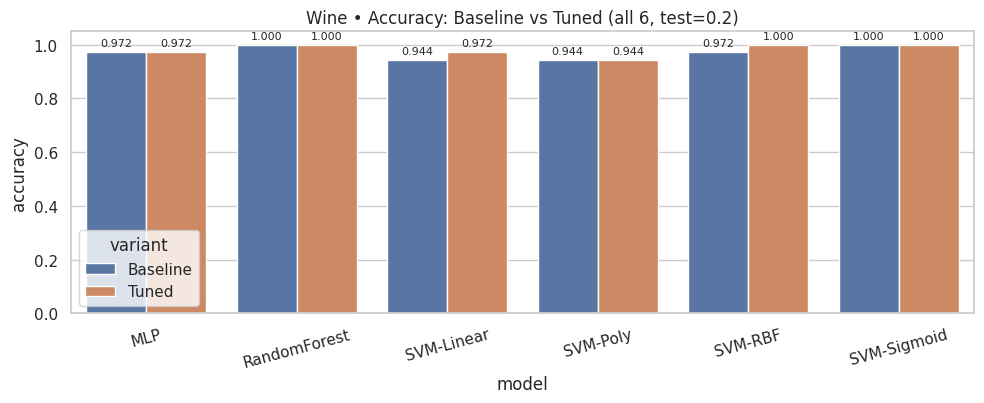

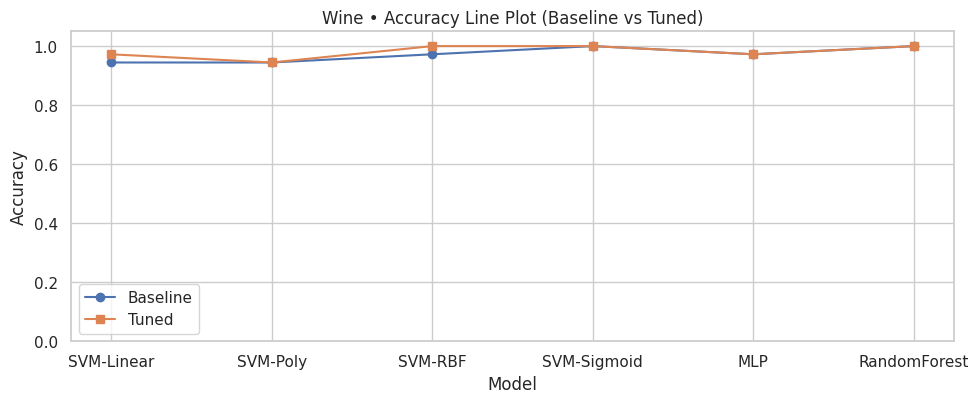

In [ ]:
from copy import deepcopy
import math

Xtr, Xte, ytr, yte = train_test_split(X_wine, y_wine, test_size=0.2, stratify=y_wine, random_state=42)

baseline = {
    "SVM-Linear":  Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="linear",  probability=True, random_state=42))]),
    "SVM-Poly":    Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="poly",    probability=True, random_state=42))]),
    "SVM-RBF":     Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf",     probability=True, random_state=42))]),
    "SVM-Sigmoid": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="sigmoid", probability=True, random_state=42))]),
    "RandomForest":Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))]),
    "MLP":         Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(max_iter=400, random_state=42))]),
}

param_grids = {
    "SVM-Linear":  {"clf__C":[0.1, 1, 3, 10]},
    "SVM-Poly":    {"clf__C":[0.1,1,3,10], "clf__degree":[2,3,4], "clf__gamma":[0.001,0.01,0.1,1]},
    "SVM-RBF":     {"clf__C":[0.1,1,3,10], "clf__gamma":[0.001,0.01,0.1,1]},
    "SVM-Sigmoid": {"clf__C":[0.1,1,3,10], "clf__gamma":[0.001,0.01,0.1,1]},
    "RandomForest":{"clf__n_estimators":[100,200,300], "clf__max_depth":[None,10,20], "clf__min_samples_split":[2,4]},
    "MLP":         {"clf__hidden_layer_sizes":[(64,32),(128,64)], "clf__learning_rate":["constant","adaptive"], "clf__alpha":[1e-5,1e-4,1e-3]},
}

def tune_one(name, base_pipe, grid, X, y, cv=5):
    gs = GridSearchCV(base_pipe, param_grid=grid, scoring="accuracy", cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)
    print(f"{name} | best CV mean: {gs.best_score_:.4f} | best params: {gs.best_params_}")
    return gs.best_estimator_, gs.best_params_, gs.best_score_

rows, preds_baseline, preds_tuned = [], {}, {}
best_estimators = {}

for name, pipe in baseline.items():
    res_b = evaluate_model(deepcopy(pipe), Xtr, Xte, ytr, yte)
    rows.append({"model": name, "variant":"Baseline", "accuracy":res_b["accuracy"], "precision":res_b["precision"], "recall":res_b["recall"], "f1":res_b["f1"]})
    preds_baseline[name] = {"y_true": res_b["y_true"], "y_pred": res_b["y_pred"], "metrics": {k:res_b[k] for k in ["accuracy","precision","recall","f1"]}}

    tuned_est, tuned_params, tuned_cv = tune_one(name, deepcopy(pipe), param_grids[name], Xtr, ytr, cv=5)
    best_estimators[name] = tuned_est
    res_t = evaluate_model(tuned_est, Xtr, Xte, ytr, yte)
    rows.append({"model": name, "variant":"Tuned", "accuracy":res_t["accuracy"], "precision":res_t["precision"], "recall":res_t["recall"], "f1":res_t["f1"]})
    preds_tuned[name] = {"y_true": res_t["y_true"], "y_pred": res_t["y_pred"], "metrics": {k:res_t[k] for k in ["accuracy","precision","recall","f1"]}}

df_cmp = pd.DataFrame(rows).sort_values(["model","variant"]).reset_index(drop=True)
display(df_cmp)

plt.figure(figsize=(10,4.2))
ax = sns.barplot(data=df_cmp, x="model", y="accuracy", hue="variant")
for c in ax.containers:
    ax.bar_label(c, fmt="%.3f", padding=3, fontsize=8)
plt.ylim(0,1.05); plt.xticks(rotation=15)
plt.title("Wine • Accuracy: Baseline vs Tuned (all 6, test=0.2)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4.2))
for variant, style in zip(["Baseline","Tuned"], ["o-","s-"]):
    subset = df_cmp[df_cmp["variant"]==variant].set_index("model").loc[order6].reset_index()
    plt.plot(subset["model"], subset["accuracy"], style, label=variant)
plt.ylim(0,1.05); plt.xlabel("Model"); plt.ylabel("Accuracy")
plt.title("Wine • Accuracy Line Plot (Baseline vs Tuned)")
plt.legend(); plt.tight_layout(); plt.show()

**OBSERVATION:**

Impact of Tuning: The comparison table and bar plots show the accuracy of the baseline models versus the tuned models on the test set (with a 0.2 test size). For some models, tuning led to a significant improvement in accuracy (e.g., SVM-Linear and SVM-RBF), while for others, the impact was minimal (e.g., MLP, RandomForest, and SVM-Sigmoid, which already achieved high accuracy in the baseline).

Best Parameters Found: The output from the tune_one function calls shows the best hyperparameters found for each model using GridSearchCV with cross-validation. These parameters represent the optimal settings within the defined search space for maximizing accuracy on the training data.
SVM Kernels: Tuning significantly improved the performance of SVM-Linear and SVM-RBF, bringing their accuracy closer to the best-performing models. SVM-Poly's performance remained similar after tuning. SVM-Sigmoid was already performing very well at baseline and tuning did not change its accuracy on this split.

MLP and RandomForest: For MLP and RandomForest, the baseline performance was already very high on this specific test split (0.2), so tuning did not result in a noticeable increase in accuracy on this split. However, the reported best cross-validation scores from the tuning process (e.g., 0.9931 for MLP and 0.9862 for RandomForest) indicate that tuning did find better parameter combinations in a cross-validation setting, which might lead to more robust performance across different data splits.

In summary, hyperparameter tuning was beneficial for some models (SVM-Linear, SVM-RBF) on the Wine dataset, helping them achieve higher accuracy. For models that already performed exceptionally well at baseline (MLP, RandomForest, SVM-Sigmoid), the direct impact of tuning on the test set accuracy of this specific split was less apparent, although the cross-validation scores indicate potential for improved robustness.

# **DATASET : HAND_WRITTEN_DIGIT**

Digits: (1797, 64) Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_54,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


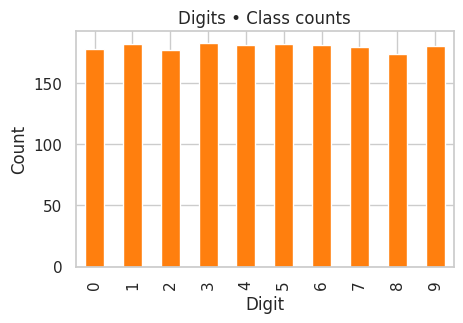

In [ ]:
from sklearn.datasets import load_digits


digits = load_digits()
X_digits = pd.DataFrame(digits.data, columns=[f"pixel_{i}" for i in range(digits.data.shape[1])])
y_digits = pd.Series(digits.target, name="target")
classes_digits = np.unique(y_digits)

print("Digits:", X_digits.shape, "Classes:", classes_digits.tolist())
display(X_digits.head())


plt.figure(figsize=(4.8,3.4))
y_digits.value_counts().sort_index().plot(kind="bar", color="tab:orange")
plt.title("Digits • Class counts"); plt.xlabel("Digit"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


,test_size,model,accuracy,precision,recall,f1
0,0.2,MLP,0.975000,0.974791,0.974683,0.974622
1,0.3,MLP,0.979630,0.979663,0.979412,0.979472
2,0.4,MLP,0.972184,0.973028,0.971983,0.972154
3,0.5,MLP,0.971079,0.971546,0.970940,0.970959
4,0.2,RandomForest,0.963889,0.964407,0.963488,0.963391
5,0.3,RandomForest,0.968519,0.969450,0.968159,0.968206
6,0.4,RandomForest,0.966620,0.967653,0.966407,0.966504
7,0.5,RandomForest,0.957731,0.959209,0.957628,0.957631
8,0.2,SVM-Linear,0.975000,0.975396,0.974833,0.974803
9,0.3,SVM-Linear,0.979630,0.980774,0.979337,0.979472


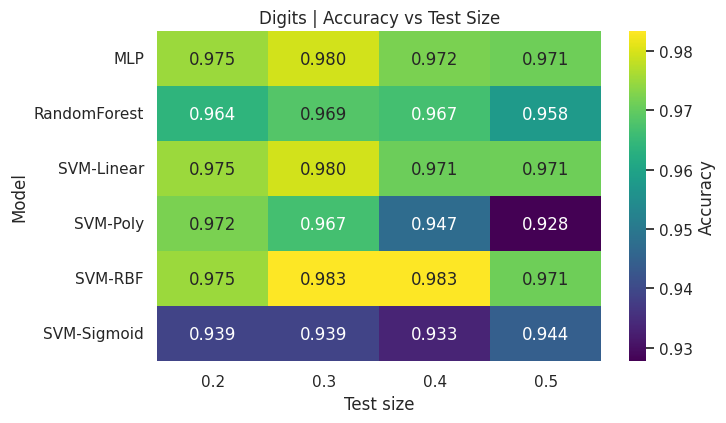


Pivot (max accuracy per model × test_size):


test_size,0.2,0.3,0.4,0.5
model,,,,
MLP,0.975000,0.979630,0.972184,0.971079
RandomForest,0.963889,0.968519,0.966620,0.957731
SVM-Linear,0.975000,0.979630,0.970793,0.971079
SVM-Poly,0.972222,0.966667,0.947149,0.927697
SVM-RBF,0.975000,0.983333,0.983310,0.971079
SVM-Sigmoid,0.938889,0.938889,0.933241,0.944383



Best accuracy per model:


,model,test_size,accuracy,precision,recall,f1
0,SVM-RBF,0.3,0.983333,0.983795,0.983152,0.983281
1,MLP,0.3,0.979630,0.979663,0.979412,0.979472
2,SVM-Linear,0.3,0.979630,0.980774,0.979337,0.979472
3,SVM-Poly,0.2,0.972222,0.975472,0.972063,0.972693
4,RandomForest,0.3,0.968519,0.969450,0.968159,0.968206
5,SVM-Sigmoid,0.5,0.944383,0.946111,0.944302,0.944536


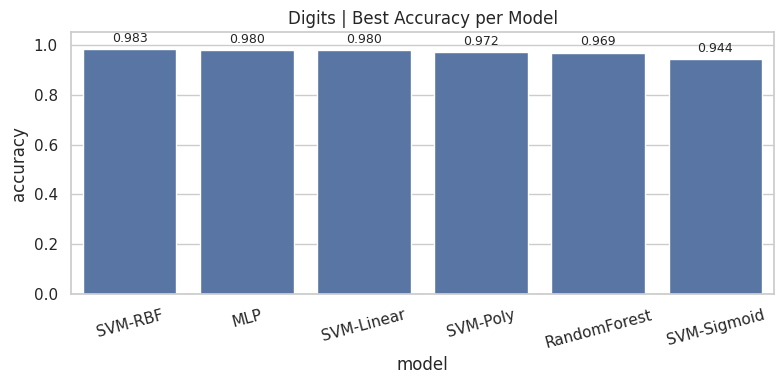

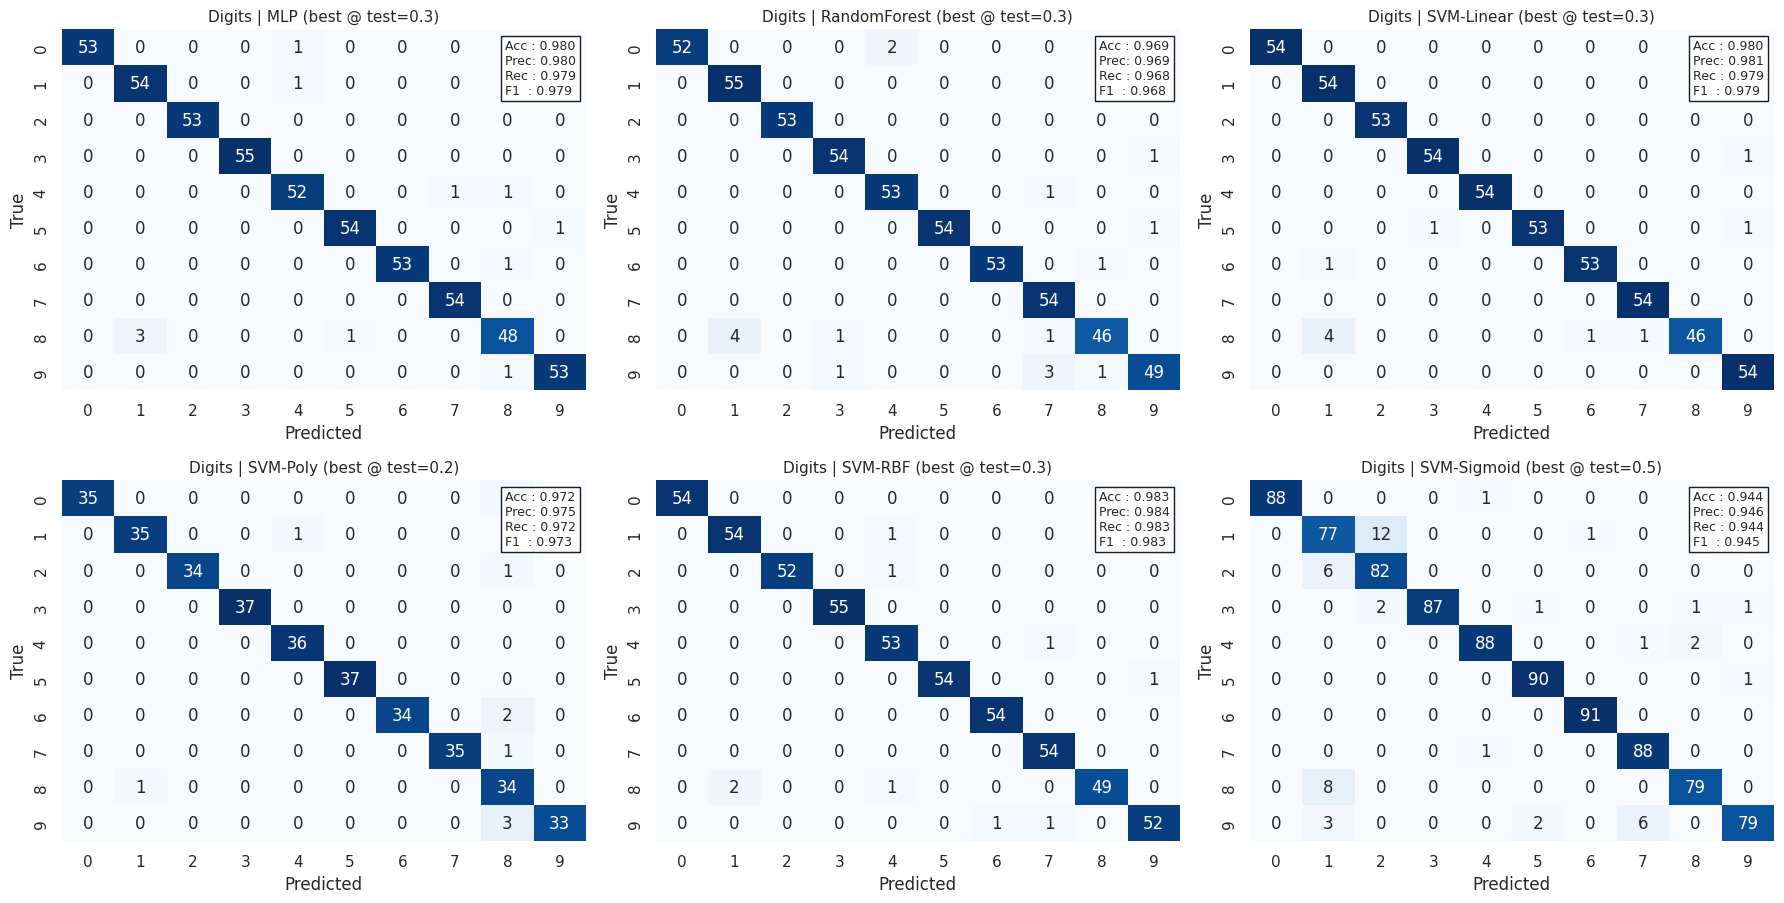

In [ ]:
pipe_d_svm_lin  = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="linear",  probability=True))])
pipe_d_svm_poly = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="poly",    probability=True))])
pipe_d_svm_rbf  = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf",     probability=True))])
pipe_d_svm_sig  = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="sigmoid", probability=True))])
pipe_d_mlp      = Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(max_iter=200, random_state=42))])
pipe_d_rf       = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))])

d_models = {
    "SVM-Linear":  pipe_d_svm_lin,
    "SVM-Poly":    pipe_d_svm_poly,
    "SVM-RBF":     pipe_d_svm_rbf,
    "SVM-Sigmoid": pipe_d_svm_sig,
    "MLP":         pipe_d_mlp,
    "RandomForest":pipe_d_rf
}
d_test_sizes = [0.2, 0.3, 0.4, 0.5]

def plot_cm_on_ax(ax, y_true, y_pred, title, metrics):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", ax=ax)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    txt = "\n".join([
        f"Acc : {metrics['accuracy']:.3f}",
        f"Prec: {metrics['precision']:.3f}",
        f"Rec : {metrics['recall']:.3f}",
        f"F1  : {metrics['f1']:.3f}",
    ])
    at = AnchoredText(txt, loc="upper right", prop=dict(size=9), frameon=True, pad=0.3, borderpad=0.5)
    ax.add_artist(at)

digits_rows = []
preds_map_d = {}

for ts in d_test_sizes:
    Xtr, Xte, ytr, yte = train_test_split(X_digits, y_digits, test_size=ts, stratify=y_digits, random_state=42)
    for name, m in d_models.items():
        res = evaluate_model(m, Xtr, Xte, ytr, yte)
        digits_rows.append({
            "test_size": ts, "model": name,
            "accuracy":res["accuracy"], "precision":res["precision"],
            "recall":res["recall"], "f1":res["f1"]
        })
        preds_map_d[(name, ts)] = {"y_true": res["y_true"], "y_pred": res["y_pred"]}

df_digits = pd.DataFrame(digits_rows).sort_values(["model","test_size"]).reset_index(drop=True)

display(df_digits)

pivot_digits = heatmap_accuracy(df_digits, title="Digits | Accuracy vs Test Size")
print("\nPivot (max accuracy per model × test_size):")
display(pivot_digits)

best_rows_d = df_digits.loc[df_digits.groupby("model")["accuracy"].idxmax()].sort_values("accuracy", ascending=False).reset_index(drop=True)
print("\nBest accuracy per model:")
display(best_rows_d[["model","test_size","accuracy","precision","recall","f1"]])
_ = bar_best_per_model(df_digits, title="Digits | Best Accuracy per Model")

def best_confusion_data_d(model_name):
    r = df_digits[df_digits["model"] == model_name]
    if r.empty: return None
    r = r.loc[r["accuracy"].idxmax()]
    ts = r["test_size"]
    preds = preds_map_d[(model_name, ts)]
    metrics = {"accuracy": r["accuracy"], "precision": r["precision"], "recall": r["recall"], "f1": r["f1"]}
    title = f"{model_name} (best @ test={ts})"
    return preds["y_true"], preds["y_pred"], title, metrics

models_to_plot_d = ["MLP", "RandomForest", "SVM-Linear", "SVM-Poly", "SVM-RBF", "SVM-Sigmoid"]

n = len(models_to_plot_d)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4.6*nrows))

axes = np.atleast_2d(axes).reshape(-1)

for i, model_name in enumerate(models_to_plot_d):
    ax = axes[i]
    data = best_confusion_data_d(model_name)
    if data is None:
        ax.axis("off")
        continue
    y_true, y_pred, title, metrics = data
    plot_cm_on_ax(ax, y_true, y_pred, f"Digits | {title}", metrics)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

**Observations**:

**Model Performance Across Test Sizes:**

The table and heatmap show the accuracy of different models (MLP, RandomForest, SVM variants) across various test sizes (0.2, 0.3, 0.4, 0.5) for the Digits dataset.
Similar to the Wine dataset, most models show high accuracy, indicating they are well-suited for this dataset as well.
SVM-RBF achieved the highest accuracy (0.9833) at a test size of 0.3.
SVM-Poly's performance decreases as the test size increases, similar to its behavior on the Wine dataset, although its initial accuracy at smaller test sizes is quite good.
SVM-Sigmoid generally has lower accuracy compared to other SVM kernels, MLP, and RandomForest on this dataset.
The heatmap visually confirms that SVM-RBF, MLP, and SVM-Linear tend to perform better and are more consistent across different test sizes, while SVM-Poly and SVM-Sigmoid show more variability and lower performance, especially at larger test sizes for SVM-Poly.

**Best Accuracy per Model:**

The bar plot and table summarizing the best accuracy per model highlight that SVM-RBF achieved the highest accuracy (0.983), followed closely by MLP and SVM-Linear (both 0.980).
SVM-Poly and RandomForest also show good performance, while SVM-Sigmoid has the lowest best accuracy among the evaluated models.

**Confusion Matrices for Best Settings:**

The confusion matrices for the best-performing settings of each model provide detailed insights into misclassifications for the multi-class Digits dataset (0-9).
For the best performing models (SVM-RBF, MLP, SVM-Linear), the confusion matrices show strong performance with high values along the diagonal and relatively low off-diagonal values, indicating good classification across most digits.
However, even the best models show some misclassifications, which is expected for a dataset with a larger number of classes like Digits compared to Wine. For example, certain digits might be confused with others (e.g., 4 and 9, or 3 and 8), which is a common challenge in digit recognition.
The confusion matrices for models with lower accuracy, like SVM-Sigmoid, show more significant off-diagonal values, indicating a higher number of misclassifications across various digit pairs.

In summary, the Digits dataset is also well-suited for these classification models, with SVM-RBF, MLP, and SVM-Linear showing particularly strong performance. The choice of test size can have an impact on the performance of some models, and the confusion matrices reveal specific digit pairs that are more challenging to classify accurately.


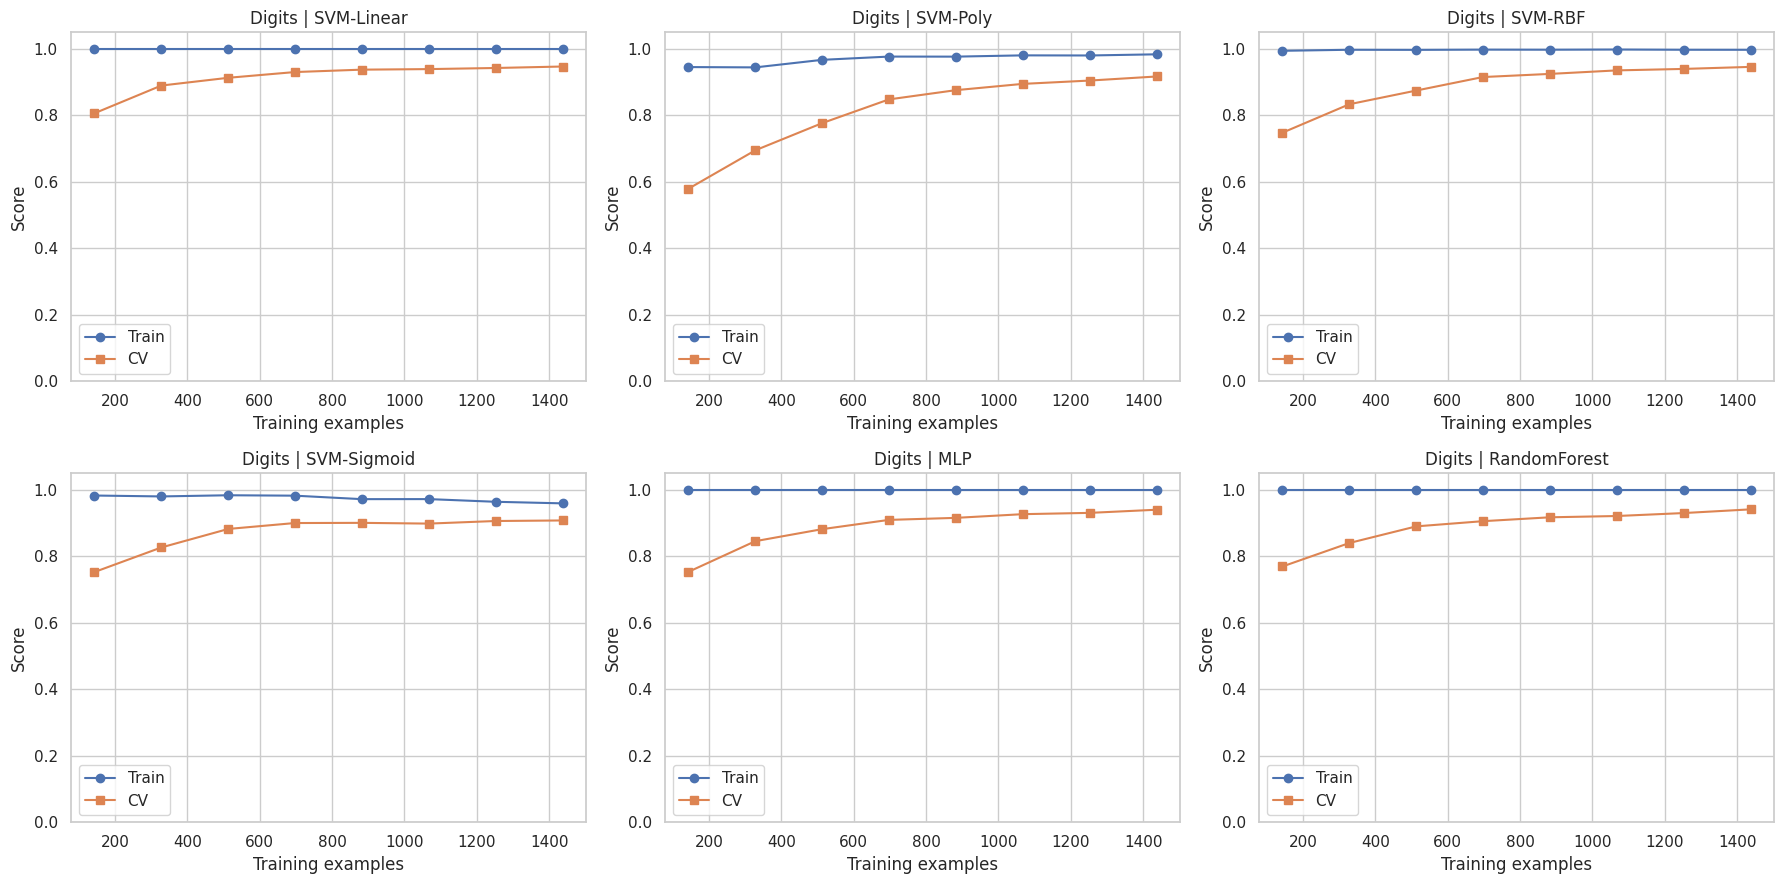

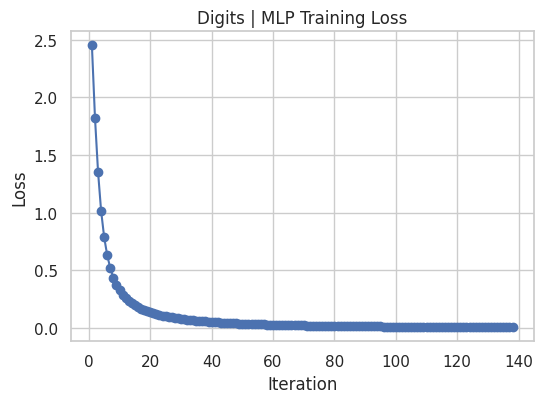

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.ravel()

for ax, name in zip(axes, order6):
    est = d_models[name]
    train_sizes, train_scores, val_scores = learning_curve(
        est, X_digits, y_digits, cv=5,
        train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1
    )
    ax.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train")
    ax.plot(train_sizes, val_scores.mean(axis=1),   marker="s", label="CV")
    ax.set_title(f"Digits | {name}")
    ax.set_xlabel("Training examples"); ax.set_ylabel("Score")
    ax.set_ylim(0, 1.05); ax.legend()

plt.tight_layout(); plt.show()

mlp_digits = d_models["MLP"].fit(X_digits, y_digits)
plot_mlp_loss_from_fitted(mlp_digits, title="Digits | MLP Training Loss")


**Observations:**

**Observations from Learning Curves:**

Similar to the Wine dataset, most models show that as the number of training examples increases, both the training and cross-validation scores improve and converge, indicating they are learning from the data.
There is generally a gap between the training and cross-validation scores, suggesting some degree of variance in the models, which is common for more complex datasets like Digits compared to Wine.
SVM-Linear, SVM-RBF, MLP, and RandomForest show good convergence and relatively high scores, indicating they are good fits for this dataset.
SVM-Poly and SVM-Sigmoid show slightly lower and more variable performance on the cross-validation set compared to other models, especially at smaller training sizes.

**Observations from MLP Training Loss Curve :**

The MLP training loss curve for the Digits dataset shows a rapid decrease in loss during the initial iterations, followed by a slower decrease as the model converges. This indicates that the MLP model is effectively learning to minimize the error on the training data.


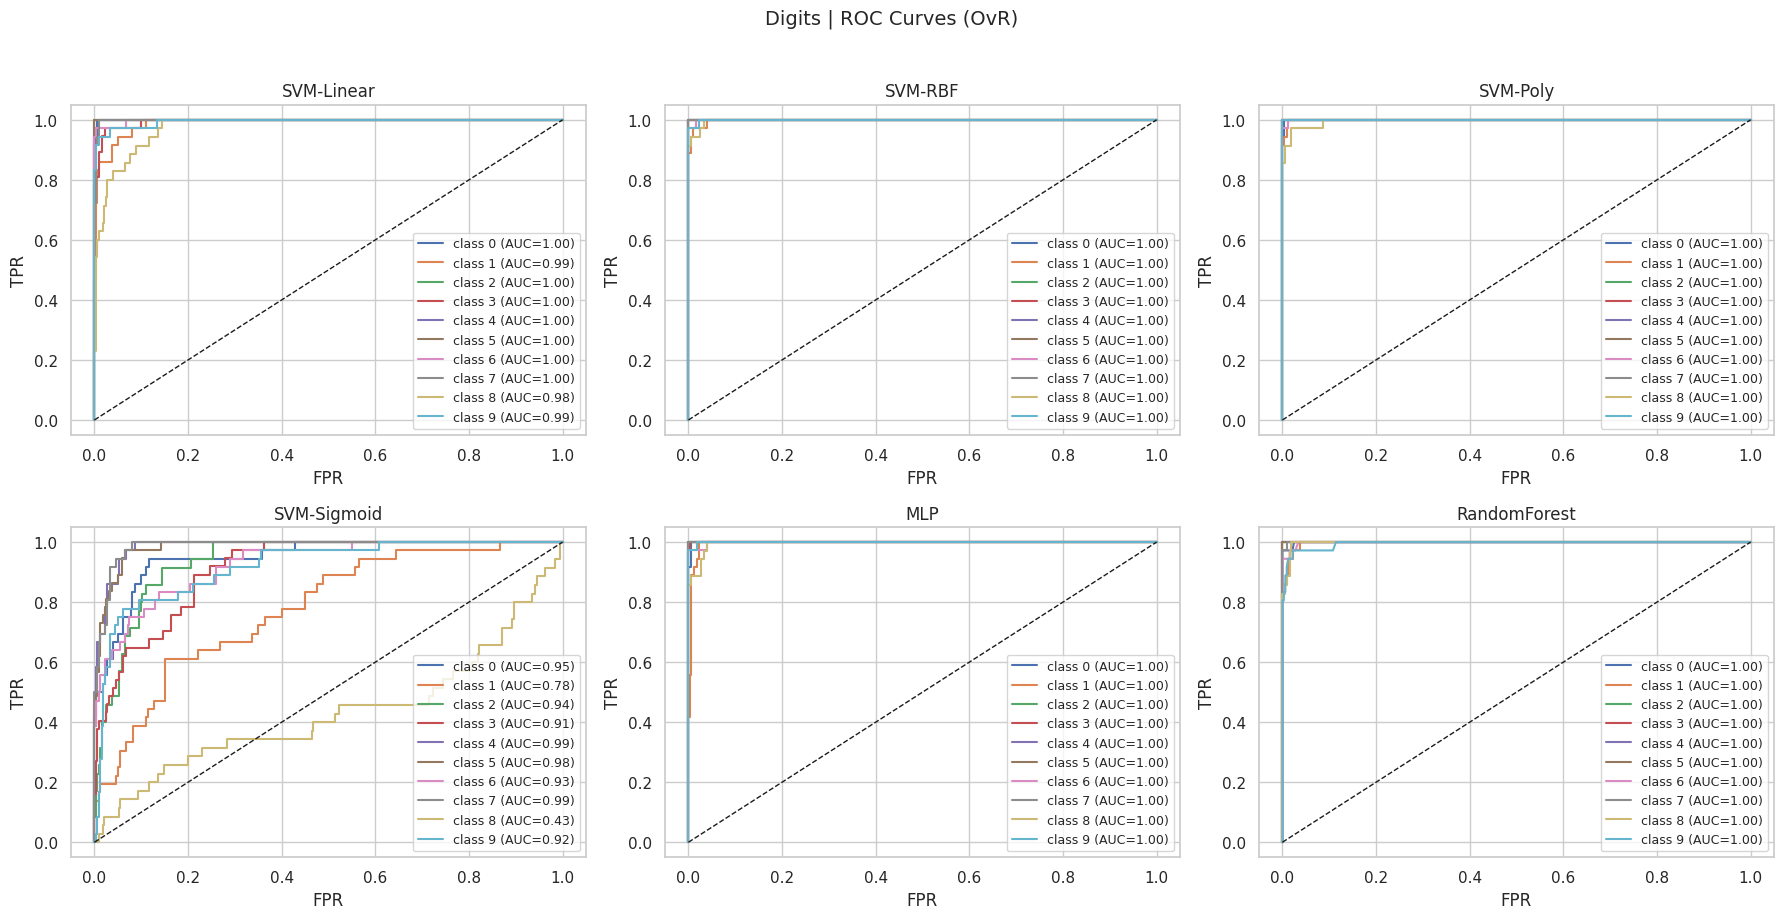

In [ ]:
Xtr_d, Xte_d, ytr_d, yte_d = train_test_split(
    X_digits, y_digits, test_size=0.2, stratify=y_digits, random_state=42
)

roc_d_models = {
    "SVM-Linear":  SVC(kernel="linear",  probability=True, random_state=42),
    "SVM-RBF":     SVC(kernel="rbf",     probability=True, random_state=42),
    "SVM-Poly":    SVC(kernel="poly",    probability=True, random_state=42),
    "SVM-Sigmoid": SVC(kernel="sigmoid", probability=True, random_state=42),
    "MLP":         MLPClassifier(max_iter=300, random_state=42),
    "RandomForest":RandomForestClassifier(n_estimators=200, random_state=42),
}

plot_multiclass_roc(
    roc_d_models, Xtr_d, Xte_d, ytr_d, yte_d,
    classes=classes_digits, title="Digits | ROC Curves (OvR)"
)


**Observations from ROC Curves:**

The OvR ROC curves for the Digits dataset show the performance of each model in discriminating between each digit class and all other classes.
Most models, including SVM-Linear, SVM-RBF, MLP, and RandomForest, demonstrate strong performance with high AUC values (close to 1.00) for most digit classes. This indicates good discriminative power for these models on the Digits dataset.
Some classes might be slightly harder to distinguish than others, as seen by minor variations in AUC values across classes for some models.
SVM-Sigmoid generally shows lower AUC values and more variability across classes compared to the other well-performing models, reinforcing the observation from the accuracy metrics that it is less effective on this dataset.
SVM-Poly also shows some lower AUC values for certain classes, consistent with its performance in the accuracy evaluation.

In summary, the learning curves and ROC curves for the Digits dataset support the earlier findings that SVM (Linear and RBF kernels), MLP, and RandomForest are well-suited for this multi-class classification task, exhibiting good learning behavior and strong discriminative capabilities. SVM-Poly and SVM-Sigmoid are less consistent in their performance on this dataset.


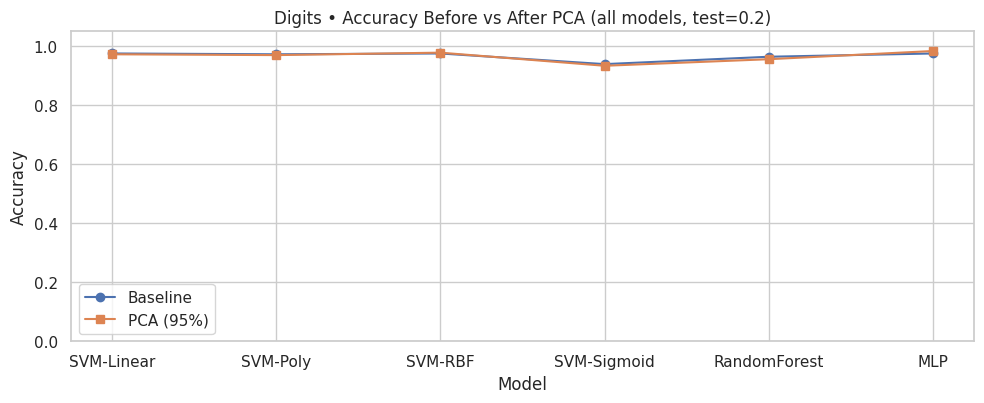

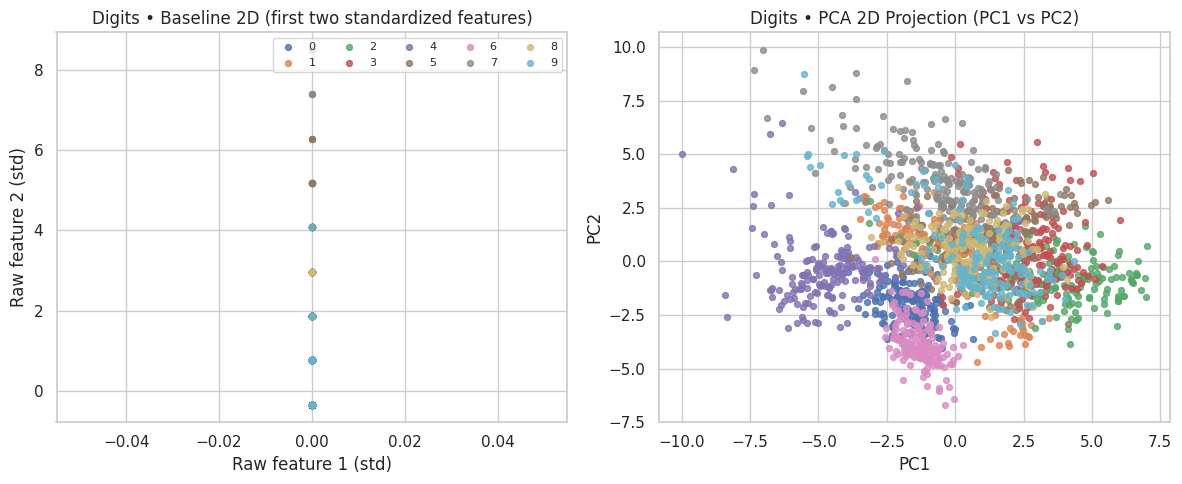

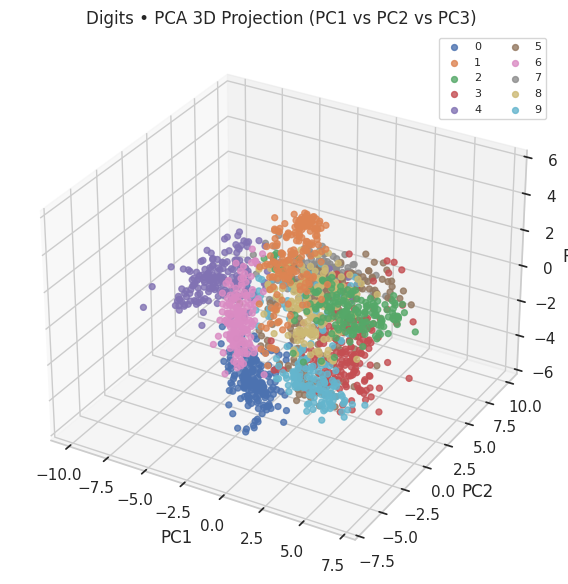

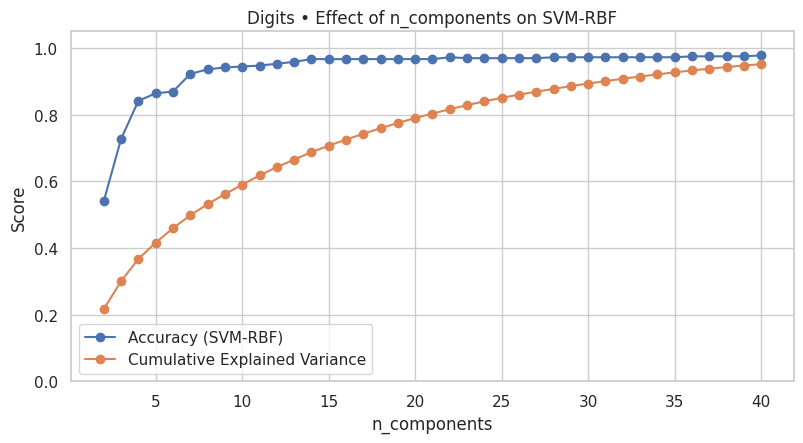

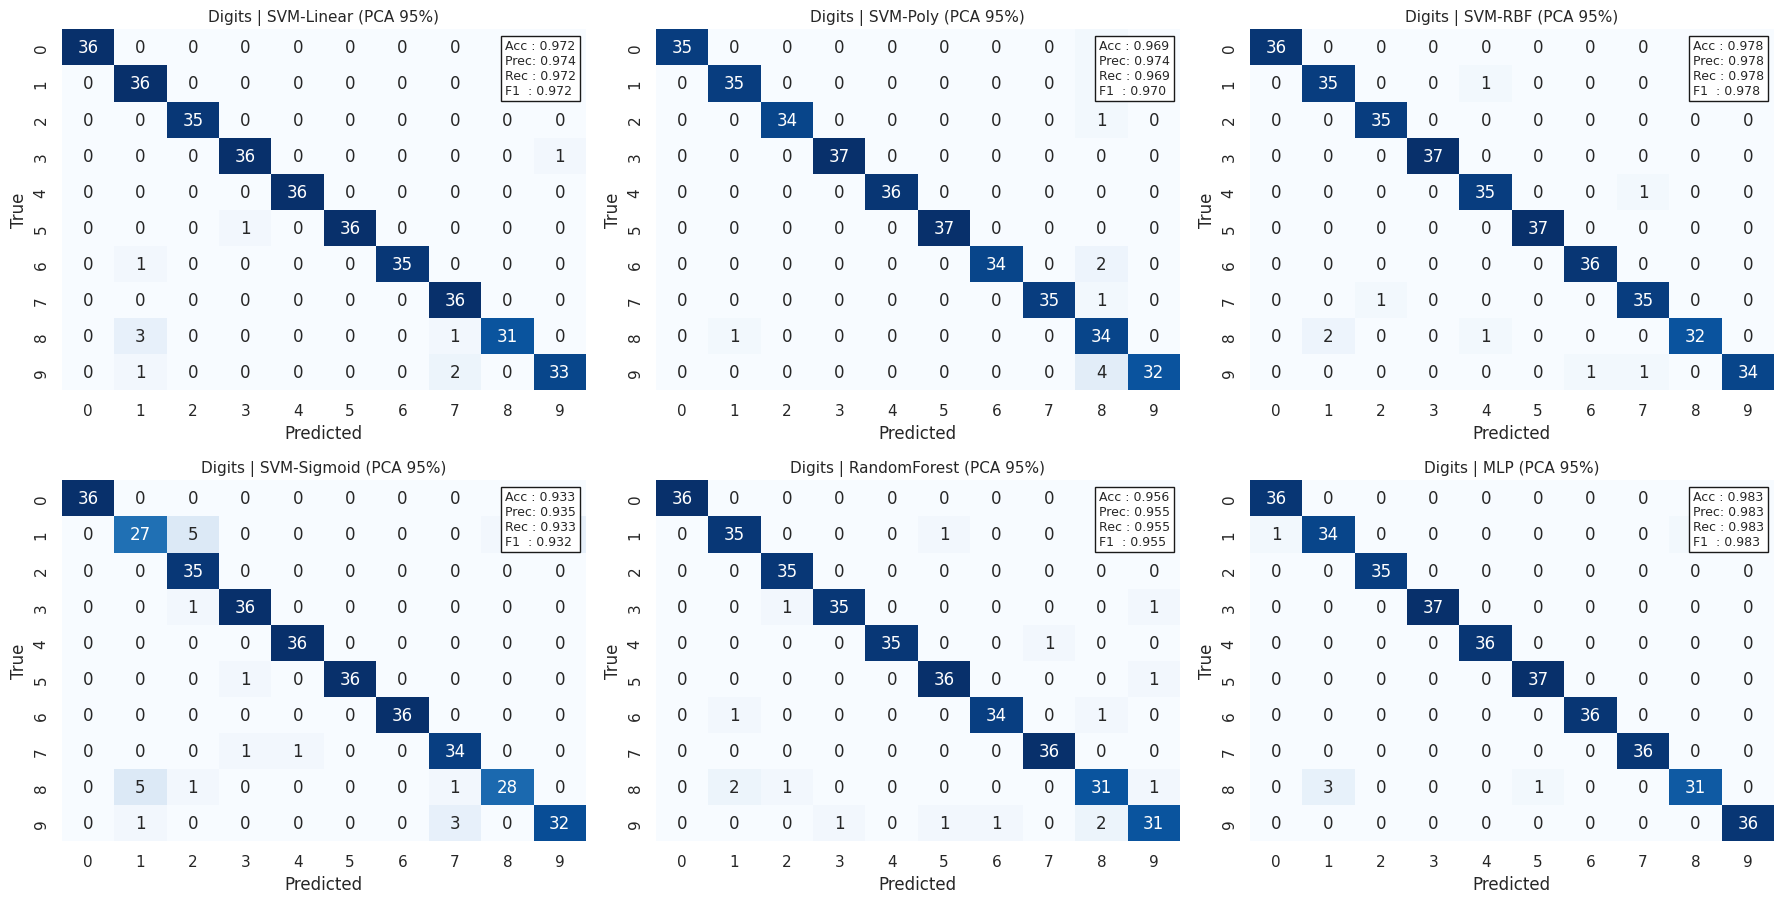

In [ ]:
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


Xtr_d, Xte_d, ytr_d, yte_d = train_test_split(
    X_digits, y_digits, test_size=0.2, stratify=y_digits, random_state=42
)

def make_pca(estimator, explained_variance=0.95):
    """Creates a pipeline with StandardScaler, PCA, and the given estimator."""
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=explained_variance, svd_solver="full")),
        ("clf", estimator)
    ])


base_all_d = {
    "SVM-Linear":  Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="linear",  probability=True))]),
    "SVM-Poly":    Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="poly",    probability=True))]),
    "SVM-RBF":     Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf",     probability=True))]),
    "SVM-Sigmoid": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="sigmoid", probability=True))]),
    "RandomForest":Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))]),
    "MLP":         Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(max_iter=200, random_state=42))]),
}
pca_all_d = {
    "SVM-Linear":  make_pca(SVC(kernel="linear",  probability=True)),
    "SVM-Poly":    make_pca(SVC(kernel="poly",    probability=True)),
    "SVM-RBF":     make_pca(SVC(kernel="rbf",     probability=True)),
    "SVM-Sigmoid": make_pca(SVC(kernel="sigmoid", probability=True)),
    "RandomForest":make_pca(RandomForestClassifier(random_state=42)),
    "MLP":         make_pca(MLPClassifier(max_iter=200, random_state=42)),
}

rows_base_all_d, rows_pca_all_d = [], []
for name, est in base_all_d.items():
    res = evaluate_model(deepcopy(est), Xtr_d, Xte_d, ytr_d, yte_d)
    rows_base_all_d.append({"model": name, "accuracy": res["accuracy"]})

for name, est in pca_all_d.items():
    res = evaluate_model(deepcopy(est), Xtr_d, Xte_d, ytr_d, yte_d)
    rows_pca_all_d.append({"model": name, "accuracy": res["accuracy"]})

df_base_all_d = pd.DataFrame(rows_base_all_d).set_index("model")
df_pca_all_d  = pd.DataFrame(rows_pca_all_d).set_index("model")

order6 = ["SVM-Linear","SVM-Poly","SVM-RBF","SVM-Sigmoid","RandomForest","MLP"]
plt.figure(figsize=(10, 4.2))
plt.plot(order6, df_base_all_d.loc[order6, "accuracy"].values, marker="o", label="Baseline")
plt.plot(order6, df_pca_all_d.loc[order6,  "accuracy"].values, marker="s", label="PCA (95%)")
plt.ylim(0, 1.05); plt.xlabel("Model"); plt.ylabel("Accuracy")
plt.title("Digits • Accuracy Before vs After PCA (all models, test=0.2)")
plt.legend(); plt.tight_layout(); plt.show()


X_std_d = StandardScaler().fit_transform(X_digits)
plt.figure(figsize=(12, 5.0))

plt.subplot(1, 2, 1)
for cls in np.unique(y_digits):
    idx = (y_digits == cls)
    plt.scatter(X_std_d[idx, 0], X_std_d[idx, 1], s=18, alpha=0.8, label=f"{cls}")
plt.xlabel("Raw feature 1 (std)"); plt.ylabel("Raw feature 2 (std)")
plt.title("Digits • Baseline 2D (first two standardized features)")
plt.legend(ncol=5, fontsize=8)

plt.subplot(1, 2, 2)
pca2_d = PCA(n_components=2, svd_solver="full").fit(X_std_d)
X_2d_d = pca2_d.transform(X_std_d)
for cls in np.unique(y_digits):
    idx = (y_digits == cls)
    plt.scatter(X_2d_d[idx, 0], X_2d_d[idx, 1], s=18, alpha=0.8, label=f"{cls}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Digits • PCA 2D Projection (PC1 vs PC2)")
plt.tight_layout(); plt.show()


plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection='3d')
pca3_d = PCA(n_components=3, svd_solver="full").fit(X_std_d)
X_3d_d = pca3_d.transform(X_std_d)
for cls in np.unique(y_digits):
    idx = (y_digits == cls)
    ax.scatter(X_3d_d[idx, 0], X_3d_d[idx, 1], X_3d_d[idx, 2], s=18, alpha=0.8, label=f"{cls}")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title("Digits • PCA 3D Projection (PC1 vs PC2 vs PC3)")
ax.legend(ncol=2, fontsize=8)
plt.tight_layout(); plt.show()



clf_name_d = "SVM-RBF"
estimator_for_sweep_d = {
    "SVM-RBF": SVC(kernel="rbf", probability=True),
    "MLP": MLPClassifier(max_iter=200, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
}[clf_name_d]


max_k_d = min(X_digits.shape[1], 40)
ks_d = list(range(2, max_k_d + 1))
accs_d, cumvar_d = [], []


sc_tr_d = StandardScaler().fit(Xtr_d)
Xtr_s_d = sc_tr_d.transform(Xtr_d); Xte_s_d = sc_tr_d.transform(Xte_d)

for k in ks_d:
    pca_k_d = PCA(n_components=k, svd_solver="full").fit(Xtr_s_d)
    Xtr_p_d = pca_k_d.transform(Xtr_s_d); Xte_p_d = pca_k_d.transform(Xte_s_d)
    clf_d = deepcopy(estimator_for_sweep_d).fit(Xtr_p_d, ytr_d)
    y_pred_d = clf_d.predict(Xte_p_d)
    accs_d.append(accuracy_score(yte_d, y_pred_d))
    cumvar_d.append(pca_k_d.explained_variance_ratio_.sum())

plt.figure(figsize=(8.2, 4.6))
plt.plot(ks_d, accs_d,   marker="o", label=f"Accuracy ({clf_name_d})")
plt.plot(ks_d, cumvar_d, marker="o", label="Cumulative Explained Variance")
plt.xlabel("n_components"); plt.ylabel("Score")
plt.title(f"Digits • Effect of n_components on {clf_name_d}")
plt.ylim(0, 1.05); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


rows_pca_all_d = []
pca_preds_all_d = {}

for name, est in pca_all_d.items():
    res = evaluate_model(deepcopy(est), Xtr_d, Xte_d, ytr_d, yte_d)
    rows_pca_all_d.append({"model": name, "accuracy": res["accuracy"]})
    pca_preds_all_d[name] = {
        "y_true": res["y_true"],
        "y_pred": res["y_pred"],
        "metrics": {k: res[k] for k in ["accuracy","precision","recall","f1"]}
    }

df_pca_all_d = pd.DataFrame(rows_pca_all_d).set_index("model")

# Define plot_cm_with_metrics_local if it's not defined globally
def plot_cm_with_metrics_local(ax, y_true, y_pred, title, metrics):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", ax=ax)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    txt = "\n".join([
        f"Acc : {metrics['accuracy']:.3f}",
        f"Prec: {metrics['precision']:.3f}",
        f"Rec : {metrics['recall']:.3f}",
        f"F1  : {metrics['f1']:.3f}",
    ])
    at = AnchoredText(txt, loc="upper right", prop=dict(size=9), frameon=True, pad=0.3, borderpad=0.5)
    ax.add_artist(at)


nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 9.2))
axes = np.atleast_2d(axes).reshape(-1)
for i, name in enumerate(order6):
    ax = axes[i]
    y_true = pca_preds_all_d[name]["y_true"]
    y_pred = pca_preds_all_d[name]["y_pred"]
    mets   = pca_preds_all_d[name]["metrics"]
    plot_cm_with_metrics_local(ax, y_true, y_pred, f"Digits | {name} (PCA 95%)", mets)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout(); plt.show()

**Observations from PCA Analysis :**

Accuracy Before vs After PCA: The plot comparing the accuracy of models before and after applying PCA (with 95% explained variance) shows varying impacts across models for the Digits dataset. For some models like SVM-RBF and MLP, there is a slight improvement in accuracy after PCA, while for others like SVM-Linear and RandomForest, there is a slight decrease. SVM-Sigmoid shows a notable decrease in accuracy with PCA (95%). This suggests that while PCA can reduce dimensionality, achieving 95% explained variance might not retain all the information necessary for optimal performance for all models on this dataset, which has a higher initial dimensionality (64 features) compared to Wine.

2D Baseline vs PCA Projection:
The scatter plot of the first two standardized raw pixel features shows very limited separation between the ten digit classes, with significant overlap.
The PCA 2D projection plot (PC1 vs PC2) shows better separation than the raw features, but there is still considerable overlap between different digit clusters, which is expected for a dataset with 10 classes reduced to 2 dimensions.

3D PCA Projection: The 3D PCA projection (PC1 vs PC2 vs PC3) provides a slightly clearer visual separation of the clusters compared to the 2D projection, indicating that the third principal component captures additional discriminatory information. However, there is still some overlap.

Effect of n_components on SVM-RBF: The plot showing the effect of the number of PCA components on the accuracy of the SVM-RBF model and the cumulative explained variance reveals that:
The cumulative explained variance increases as more components are included, reaching near 95% around 20 components.

The accuracy of the SVM-RBF model on the test set generally increases with the number of components and plateaus around 15-20 components. Using more components beyond this range does not significantly improve accuracy and might even lead to a slight decrease, potentially due to including noise in higher dimensions. This suggests that a reduced number of components (around 15-20) can be sufficient for good performance with SVM-RBF on this dataset while reducing dimensionality.


SVM-Linear | best CV mean: 0.9770 | best params: {'clf__C': 0.1}
SVM-Poly | best CV mean: 0.9875 | best params: {'clf__C': 0.1, 'clf__degree': 3, 'clf__gamma': 0.1}
SVM-RBF | best CV mean: 0.9833 | best params: {'clf__C': 3, 'clf__gamma': 0.01}
SVM-Sigmoid | best CV mean: 0.9715 | best params: {'clf__C': 10, 'clf__gamma': 0.001}
RandomForest | best CV mean: 0.9763 | best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
MLP | best CV mean: 0.9742 | best params: {'clf__alpha': 1e-05, 'clf__hidden_layer_sizes': (64, 32), 'clf__learning_rate': 'constant'}


,model,variant,accuracy,precision,recall,f1
0,MLP,Baseline,0.975000,0.974791,0.974683,0.974622
1,MLP,Tuned,0.966667,0.967079,0.966504,0.966411
2,RandomForest,Baseline,0.963889,0.964407,0.963488,0.963391
3,RandomForest,Tuned,0.969444,0.970197,0.969048,0.968946
4,SVM-Linear,Baseline,0.975000,0.975396,0.974833,0.974803
5,SVM-Linear,Tuned,0.983333,0.983448,0.983095,0.983081
6,SVM-Poly,Baseline,0.972222,0.975472,0.972063,0.972693
7,SVM-Poly,Tuned,0.994444,0.994520,0.994444,0.994405
8,SVM-RBF,Baseline,0.975000,0.975960,0.974762,0.974847
9,SVM-RBF,Tuned,0.980556,0.981223,0.980317,0.980374


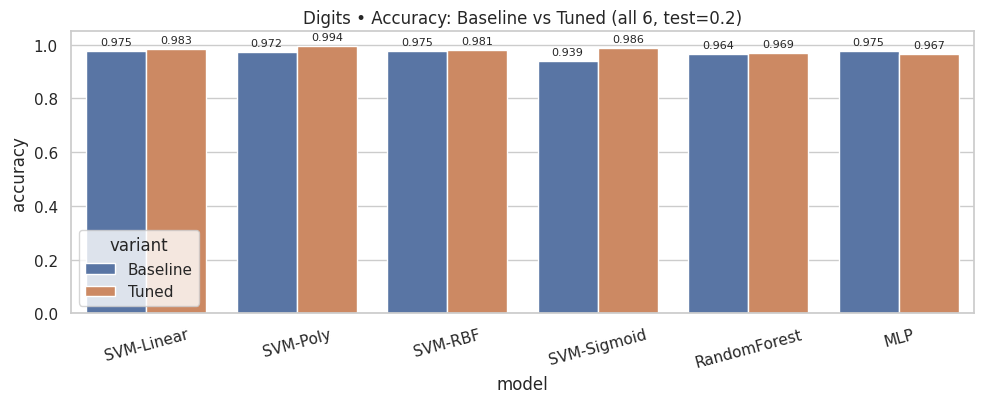

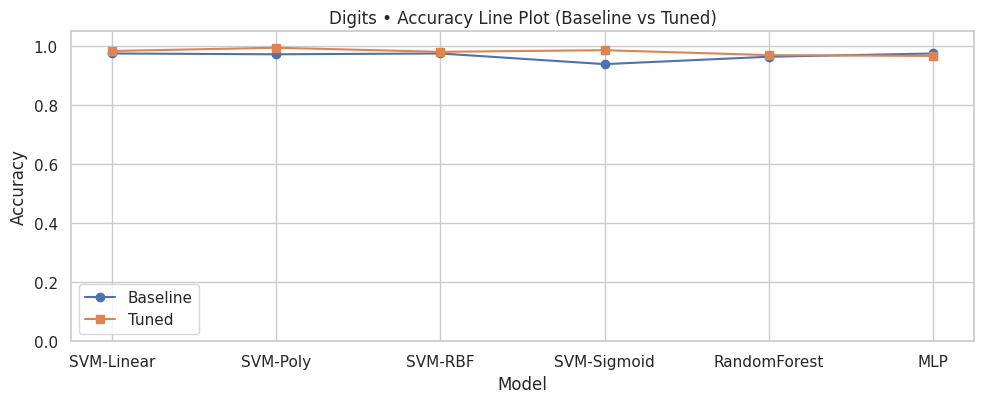

In [ ]:
from copy import deepcopy
import math
from sklearn.model_selection import GridSearchCV


Xtr_d, Xte_d, ytr_d, yte_d = train_test_split(
    X_digits, y_digits, test_size=0.2, stratify=y_digits, random_state=42
)


baseline_d = {
    "SVM-Linear":  Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="linear",  probability=True, random_state=42))]),
    "SVM-Poly":    Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="poly",    probability=True, random_state=42))]),
    "SVM-RBF":     Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf",     probability=True, random_state=42))]),
    "SVM-Sigmoid": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="sigmoid", probability=True, random_state=42))]),
    "RandomForest":Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))]),
    "MLP":         Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(max_iter=400, random_state=42))]),
}


param_grids_d = {
    "SVM-Linear":  {"clf__C":[0.1, 1, 3, 10]},
    "SVM-Poly":    {"clf__C":[0.1,1,3,10], "clf__degree":[2,3,4], "clf__gamma":[0.001,0.01,0.1,1]},
    "SVM-RBF":     {"clf__C":[0.1,1,3,10], "clf__gamma":[0.001,0.01,0.1,1]},
    "SVM-Sigmoid": {"clf__C":[0.1,1,3,10], "clf__gamma":[0.001,0.01,0.1,1]},
    "RandomForest":{"clf__n_estimators":[100,200,300], "clf__max_depth":[None,10,20], "clf__min_samples_split":[2,4]},
    "MLP":         {"clf__hidden_layer_sizes":[(64,32),(128,64)], "clf__learning_rate":["constant","adaptive"], "clf__alpha":[1e-5,1e-4,1e-3]},
}

def tune_one_d(name, base_pipe, grid, X, y, cv=5):
    gs = GridSearchCV(base_pipe, param_grid=grid, scoring="accuracy", cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)
    print(f"{name} | best CV mean: {gs.best_score_:.4f} | best params: {gs.best_params_}")
    return gs.best_estimator_, gs.best_params_, gs.best_score_


rows_d, preds_baseline_d, preds_tuned_d = [], {}, {}
best_estimators_d = {}

for name, pipe in baseline_d.items():

    res_b = evaluate_model(deepcopy(pipe), Xtr_d, Xte_d, ytr_d, yte_d)
    rows_d.append({"model": name, "variant":"Baseline", "accuracy":res_b["accuracy"], "precision":res_b["precision"], "recall":res_b["recall"], "f1":res_b["f1"]})
    preds_baseline_d[name] = {"y_true": res_b["y_true"], "y_pred": res_b["y_pred"], "metrics": {k:res_b[k] for k in ["accuracy","precision","recall","f1"]}}


    tuned_est, tuned_params, tuned_cv = tune_one_d(name, deepcopy(pipe), param_grids_d[name], Xtr_d, ytr_d, cv=5)
    best_estimators_d[name] = tuned_est
    res_t = evaluate_model(tuned_est, Xtr_d, Xte_d, ytr_d, yte_d)
    rows_d.append({"model": name, "variant":"Tuned", "accuracy":res_t["accuracy"], "precision":res_t["precision"], "recall":res_t["recall"], "f1":res_t["f1"]})
    preds_tuned_d[name] = {"y_true": res_t["y_true"], "y_pred": res_t["y_pred"], "metrics": {k:res_t[k] for k in ["accuracy","precision","recall","f1"]}}


df_cmp_d = pd.DataFrame(rows_d).sort_values(["model","variant"]).reset_index(drop=True)
display(df_cmp_d)


order6 = ["SVM-Linear","SVM-Poly","SVM-RBF","SVM-Sigmoid","RandomForest","MLP"]

plt.figure(figsize=(10,4.2))
ax = sns.barplot(data=df_cmp_d, x="model", y="accuracy", hue="variant", order=order6)
for c in ax.containers:
    ax.bar_label(c, fmt="%.3f", padding=3, fontsize=8)
plt.ylim(0,1.05); plt.xticks(rotation=15)
plt.title("Digits • Accuracy: Baseline vs Tuned (all 6, test=0.2)")
plt.tight_layout(); plt.show()


plt.figure(figsize=(10,4.2))
for variant, style in zip(["Baseline","Tuned"], ["o-","s-"]):
    subset = df_cmp_d[df_cmp_d["variant"]==variant].set_index("model").loc[order6].reset_index()
    plt.plot(subset["model"], subset["accuracy"], style, label=variant)
plt.ylim(0,1.05); plt.xlabel("Model"); plt.ylabel("Accuracy")
plt.title("Digits • Accuracy Line Plot (Baseline vs Tuned)")
plt.legend(); plt.tight_layout(); plt.show()

**Observations from Tuning :**

Impact of Tuning: The comparison table and bar plots show the accuracy of baseline versus tuned models on the Digits test set (with a 0.2 test size). Hyperparameter tuning had a noticeable positive impact on the performance of several models, most significantly on SVM-Poly and SVM-Sigmoid, bringing their accuracy closer to the best-performing models. SVM-Linear and SVM-RBF also saw improvements, while MLP and RandomForest had smaller changes in accuracy on this specific split.

Best Parameters Found: The tuning process identified the best hyperparameters for each model using cross-validation. These tuned parameters are expected to yield better or more robust performance.

SVM Kernels: Tuning dramatically improved the performance of SVM-Poly and SVM-Sigmoid on this dataset. SVM-Linear and SVM-RBF also benefited from tuning.
MLP and RandomForest: While already performing well at baseline, tuning provided slight improvements for RandomForest on this test split. The tuned MLP performed slightly worse on this specific split compared to its baseline, though the cross-validation scores during tuning would indicate the best parameters found in a more generalized setting.

In summary, for the Digits dataset, PCA can help with dimensionality reduction and visual separation of classes, and using an optimal number of components can maintain or slightly improve model performance. Hyperparameter tuning proved beneficial for improving the accuracy of most models, particularly the SVM variants.
